# Analysis code for the manuscript "Competition between phage lambda receptor specialists reshapes fitness landscapes to promote diversification and speciation"

This notebook downloads deep sequencing data from the sequence read archive, performs all of the analyses related to measuring fitness landscapes in the presence of different competitor viruses, analyzes the fitness landscapes, simulates lambda evolution using experimentally measured fitness landscapes, and produces all main results/figures reported in the manuscript.

Written by Mike Doud, July 2023

## Setting up computing environment

These analyses were run using the conda environment specified by `notebookenv.yml`:  
- Create the environment with `conda env create -f noteboookenv.yml`
- Activate the environment with `conda activate notebookenv`

In [1]:
from pathlib import Path
import glob
import subprocess

from numpy.random import normal
import itertools
from IPython.display import Image, display

import pandas as pd
import matplotlib.pyplot as plt
from scripts import myutils


In [2]:
# define directory paths used throughout the analyses:
outputpath = Path('./output-notebook/')
fastqpath = Path('./fastqfiles/')
sr_files_path = Path('%s/selectionrate/srfiles/' % outputpath)
sr_path = Path('%s/selectionrate/' % outputpath)
specialists_path = Path('%s/selectionrate/specialists/' % (outputpath))
sims_path = Path('%s/simulations/' % outputpath)
noisetune_path = Path('%s/simulations/noisetuning' % outputpath)
for path in [outputpath, fastqpath, sr_files_path, sr_path, specialists_path, sims_path, noisetune_path]:
    path.mkdir(parents=True, exist_ok=True)

## Specifying sample names and accession numbers
The manuscript contains detailed descriptions of the methods of the experiments. In brief, there are deep sequencing datasets for the independently generated mutant virus libraries A and B (*LibA-*, *LibB-*), before (*-pre*) and after competition against three competitor viruses (*Gen*= receptor generalist strain EvoC; *Lspec*=L-specialist, *Ospec*=O-specialist). If *LamB* or *OmpF* is listed in the sample name, it designates the competition flask only contained host cells expressing that receptor (technically, OmpF-knockout and LamB-knockout, respectively). In the remaining 18 samples derived from virus competition experiments, the competition flasks contained equal amounts of hosts expressing LamB or OmpF (technically, an equal mixture of OmpF-knockout and LamB-knockout cells). Three replicate competition flasks were cultured and sequenced in parallel for every combination of library/competitor/host. The lysogen sub-libraries were also sequenced after mutagenesis and prior to induction of virus libraries; these samples are included here simply to see that all of the intended combinatorial genotypes were included at the mutagenesis step.

In [3]:
# these are the SRA accession numbers corresponding to each experimental sample.
accessions = {  'SRR24950257':'LibA_pre',
                'SRR24950256':'LibA_vGen_1',
                'SRR24950245':'LibA_vGen_2',
                'SRR24950234':'LibA_vGen_3',
                'SRR24950227':'LibA_vGen_LamB_1',
                'SRR24950226':'LibA_vGen_LamB_2',
                'SRR24950225':'LibA_vGen_LamB_3',
                'SRR24950224':'LibA_vGen_OmpF_1',
                'SRR24950223':'LibA_vGen_OmpF_2',
                'SRR24950222':'LibA_vGen_OmpF_3',
                'SRR24950255':'LibA_vLspec_1',
                'SRR24950254':'LibA_vLspec_2',
                'SRR24950253':'LibA_vLspec_3',
                'SRR24950252':'LibA_vOspec_1',
                'SRR24950251':'LibA_vOspec_2',
                'SRR24950250':'LibA_vOspec_3',
                'SRR24950249':'LibB_pre',
                'SRR24950248':'LibB_vGen_1',
                'SRR24950247':'LibB_vGen_2',
                'SRR24950246':'LibB_vGen_3',
                'SRR24950244':'LibB_vGen_LamB_1',
                'SRR24950243':'LibB_vGen_LamB_2',
                'SRR24950242':'LibB_vGen_LamB_3',
                'SRR24950241':'LibB_vGen_OmpF_1',
                'SRR24950240':'LibB_vGen_OmpF_2',
                'SRR24950239':'LibB_vGen_OmpF_3',
                'SRR24950238':'LibB_vLspec_1',
                'SRR24950237':'LibB_vLspec_2',
                'SRR24950236':'LibB_vLspec_3',
                'SRR24950235':'LibB_vOspec_1',
                'SRR24950233':'LibB_vOspec_2',
                'SRR24950232':'LibB_vOspec_3',
                'SRR24950231':'lyso_1a',
                'SRR24950230':'lyso_1b',
                'SRR24950229':'lyso_2a',
                'SRR24950228':'lyso_2b'}

samples = list(accessions.values())
competition_samples = [s for s in samples if 'lyso' not in s]
lysogen_samples = [s for s in samples if 'lyso' in s]

## Downloading fastq files from SRA
We will use `prefetch` and `fastq-dump` to download `.sra` files for each sample, and extract read 1 and 2 `.fastq.gz` files. This requires installing the SRA toolkit (https://github.com/ncbi/sra-tools/wiki/02.-Installing-SRA-Toolkit). For example,

```
curl --output sratoolkit.tar.gz https://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/current/sratoolkit.current-mac64.tar.gz
tar -vxzf sratoolkit.tar.gz
export PATH=$PATH:$PWD/sratoolkit.3.0.5-mac64/bin
vdb-config -i
```

I installed the SRA toolkit in the user home directory `~/` and set the user-repository directory to to `~/sradownload`.

In [24]:
sratoolkitpath = '~/sratoolkit.3.0.5-mac64/bin/'

In [ ]:
for accession, sample_id in accessions.items():
    
    expect_r1_file = '%s/%s-%s_1.fastq.gz' % (fastqpath, accession, sample_id)
    expect_r2_file = '%s/%s-%s_2.fastq.gz' % (fastqpath, accession, sample_id)
    if not Path(expect_r1_file).is_file() or not Path(expect_r2_file).is_file():
        
        print("Downloading %s: %s" % (accession, sample_id))
        
        # download the .sra with prefetch
        command = '%s/prefetch ' % sratoolkitpath + accession
        print("About to execute: %s" % command)
        subprocess.call(command, shell=True)
        
        # add the sample_id the filename
        command = 'mv ~/sradownload/sra/%s.sra ~/sradownload/sra/%s-%s.sra' % (accession, accession, sample_id)
        print("About to execute: %s" % command)
        subprocess.call(command, shell=True)
        
        # extract fastq.gz from .sra using fastq-dump:
        command = '%s/fastq-dump -O %s --gzip --split-files ~/sradownload/sra/%s-%s.sra' % (sratoolkitpath, fastqpath, accession, sample_id)
        print("About to execute: %s" % command)
        subprocess.call(command, shell=True)
        
    else:
        print("fastq files for %s already exist" % sample_id)

## Computing genotype frequencies from fastq files

`parse_FASTQ.py` parses paired reads from FASTQ files, performs error correction by building consensus sequences for each molecular barcode sequence, converts the amplicon sequence to a formatted binary genotype (eg, [000000000] is unmutated, "wild-type", EvoC J sequence; [101000000] is the genotype containing mutations at sites 1 and 3, etc), and outputs a `.csv` file containing: formatted genotype, counts, frequency(%). 

Since the lysogen library sequencing and competition sequencing were performed using slightly different amplicon strategies, `parse_FASTQ.py` requires the appropriate `--ampliconversion` argument. This allows the script to align the reads to the approriate amplicon sequence.

In [ ]:
for sample in samples:
    checkfile = str(outputpath) + '/genotypecounts/countsfiles/%s_formattedcounts.csv' % sample
    if not Path(checkfile).is_file():
        if sample in lysogen_samples:
            ampliconversion = 'short'
        else:
            ampliconversion = 'longest'
        command = "python scripts/parse_FASTQ.py %s %s %s --ampliconversion %s\n" \
                    % (sample, fastqpath, outputpath, ampliconversion)
        print("calling command:\n%s" % command)
        subprocess.call(command, shell=True)
    else:
        print("counts file already generated for %s" % sample)

this generated files listing genotype counts and frequency for every sample. For example:

In [1]:
!head ./output-notebook/genotypecounts/countsfiles/LibA_vGen_1_formattedcounts.csv

genotype,counts,frequency(%)
[001000001], 180940, 14.066779
[010011101], 83119, 6.461903
[010000001], 61269, 4.763223
[001000000], 52133, 4.052965
[101000101], 47675, 3.706387
[001011101], 44180, 3.434676
[011011101], 30231, 2.350242
[011000001], 29523, 2.295200
[111000101], 28291, 2.199421


`analyze_counts.py` analyzes the `counts.csv` files for all samples and summarizes sequencing depth and genotype sampling:

In [ ]:
sample_id_stringed = ' '.join(samples) 
command = "python scripts/analyze_counts.py %s %s" % (outputpath, sample_id_stringed)
print("calling command:\n%s" % command)
subprocess.call(command, shell=True)

In [9]:
depth_summary = pd.read_csv(str(outputpath) + '/genotypecounts/depthstats/depth_summary.csv')
depth_summary

,sample,total_reads,retained_reads,total_barcodes,retained_barcodes
0,LibA_pre,21536758,20322420,9615680,1504884
1,LibA_vGen_1,18485491,17421123,7732259,1286293
2,LibA_vGen_2,18484112,17349530,7393032,1278832
3,LibA_vGen_3,18059625,17001858,7353352,1284544
4,LibA_vGen_LamB_1,18121384,16984788,6304149,1032342
5,LibA_vGen_LamB_2,20548272,19373665,9263231,1474078
6,LibA_vGen_LamB_3,28016680,26403612,11034429,1306940
7,LibA_vGen_OmpF_1,18440873,17399028,7759028,1311059
8,LibA_vGen_OmpF_2,18308966,17243123,7658868,1262205
9,LibA_vGen_OmpF_3,21257346,20062589,8431809,1349872


How many of the intended combinatorial genotypes are observed in each sample? The following table lists this information. Note that the lysogen sub-libraries `1` and `2` each contain half of the full combinatorial library (ie, 256 genotypes in each sub-library), since the sub-libraries were made indepdendently on genetic backgrounds *with* and *without* the 9th mutation. The main conclusions are: 1. lysogen sub-libraries contain all intended genotypes, and 2. pre-selection virus libraries contain all intended genotypes.

In [7]:
!cat ./output-notebook/genotypecounts/depthstats/librarysampling.txt

LibA_pre: 512/512 genotype variants observed.
LibA_vGen_1: 362/512 genotype variants observed.
LibA_vGen_2: 347/512 genotype variants observed.
LibA_vGen_3: 345/512 genotype variants observed.
LibA_vGen_LamB_1: 495/512 genotype variants observed.
LibA_vGen_LamB_2: 499/512 genotype variants observed.
LibA_vGen_LamB_3: 498/512 genotype variants observed.
LibA_vGen_OmpF_1: 243/512 genotype variants observed.
LibA_vGen_OmpF_2: 242/512 genotype variants observed.
LibA_vGen_OmpF_3: 263/512 genotype variants observed.
LibA_vLspec_1: 385/512 genotype variants observed.
LibA_vLspec_2: 386/512 genotype variants observed.
LibA_vLspec_3: 379/512 genotype variants observed.
LibA_vOspec_1: 452/512 genotype variants observed.
LibA_vOspec_2: 449/512 genotype variants observed.
LibA_vOspec_3: 460/512 genotype variants observed.
LibB_pre: 512/512 genotype variants observed.
LibB_vGen_1: 397/512 genotype variants observed.
LibB_vGen_2: 380/512 genotype variants observed.
LibB_vGen_3: 373/512 genotype var

`plot_genotypesampling.py` plots rank-ordered genotype frequency plots for a set of samples. This is useful to examine the distribution of mutation frequencies before and after selection, and also to give a subjective impression of purifying selection removing stop codons from the pre-selection library. 

First we can look at genotype sampling within the lysogen sub-libraries:

calling command:
python scripts/plot_genotypesampling.py output-notebook lyso_1a lyso_1b lyso_2a lyso_2b 1 4 --nplots 4 --ylim 2 --xlim 300 --plotfileprefix lysogen


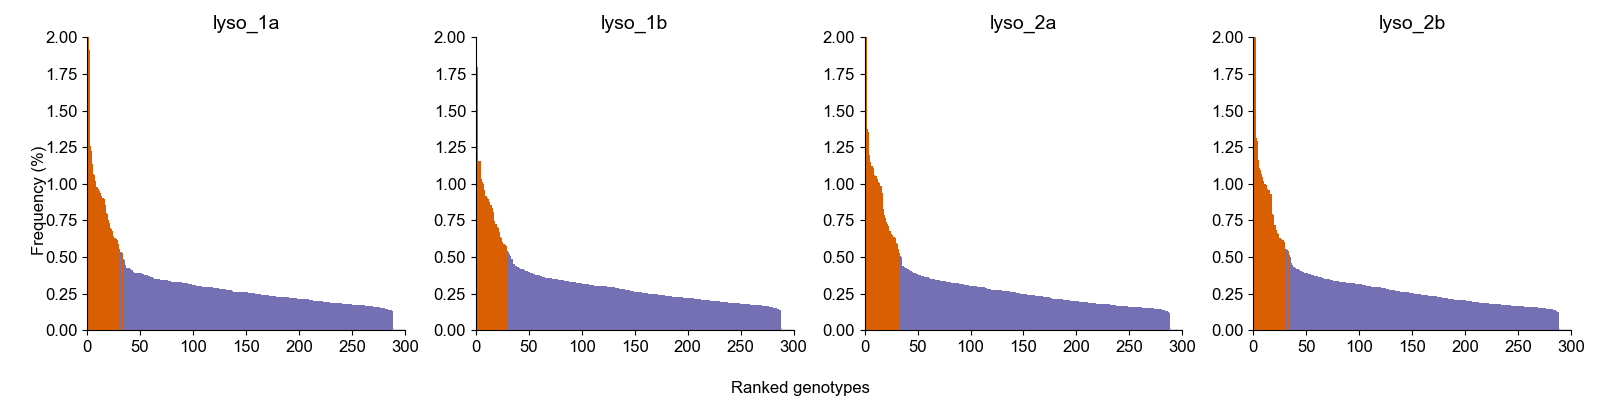

In [4]:
sample_id_stringed = ' '.join(lysogen_samples) 
command = "python scripts/plot_genotypesampling.py %s %s 1 4 --nplots 4 --ylim 2 --xlim 300 --plotfileprefix lysogen" % (outputpath, sample_id_stringed)
print("calling command:\n%s" % command)
subprocess.call(command, shell=True)
display(Image('./output-notebook/genotypecounts/rankorderplots/prog-stop-LF/linear/genotypesampling-lysogen-linear.png'))

We see above that each of the lysogen sub-libraries contains initially many stop-codon containing genotypes at the highest frequencies (red), followed by exactly 256 genotypes from the intended combinatorial library (purple) all of which are at a relatively similar frequence of ~0.3%, followed by a very steep drop in frequency to the remaining genotypes which are not visible in these plots which represent other low-frequency entities that we are not concerned with.

It is not surprising that there are many stop-codon containing genotypes remaining in the lysogen libraries; this was an intended result since MAGE was performed on a template sequence that contained stop codons and the mutagenesis efficiency is nowhere near perfect. We expected many remaining stop-codon containing genotypes due to incomplete recombination during MAGE, and later we will see that even as viruses are produced containing residual J genes with stop codons, these genotypes are strongly selected against during the competition experiment (see below). 

Next we can look at genotype sampling in the mutant virus libraries that were grown from the lysogen sublibraries; we will look at the pre-selection library samples and the three replicate competition flask samples for each library/environment combination.

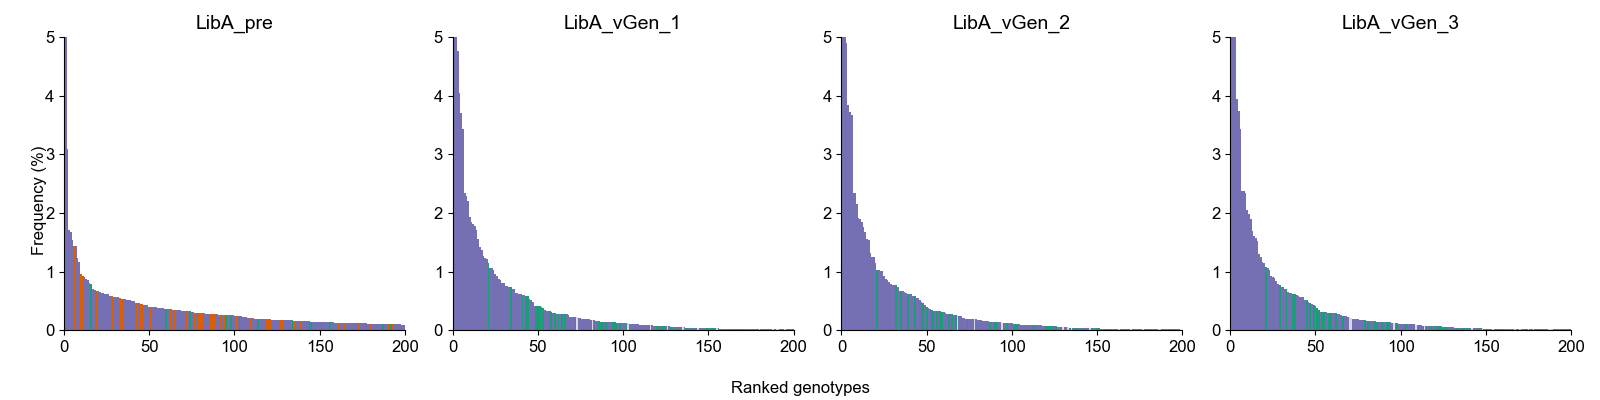

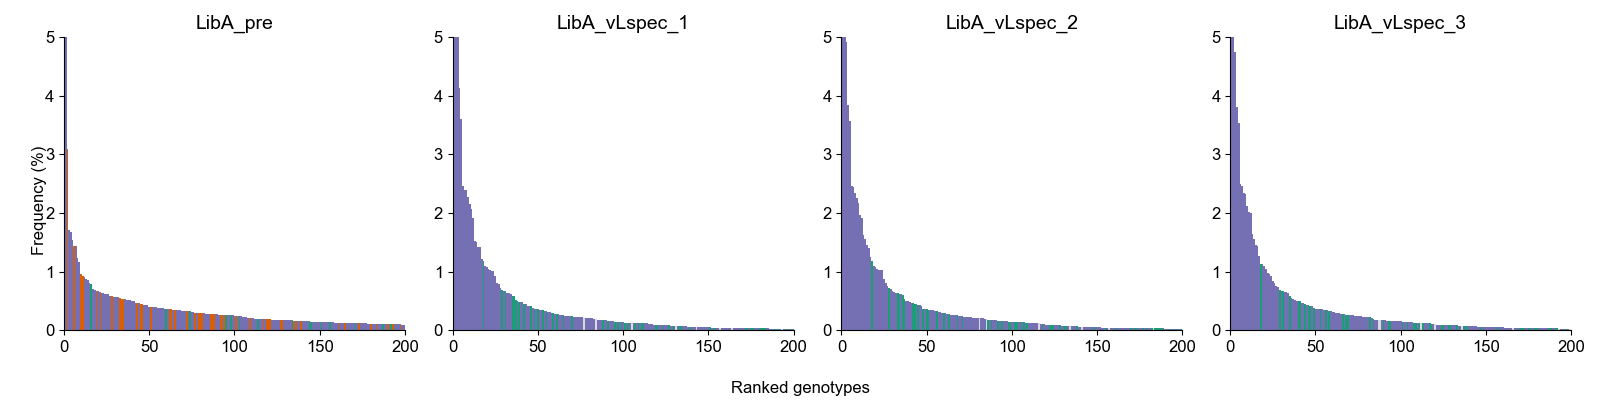

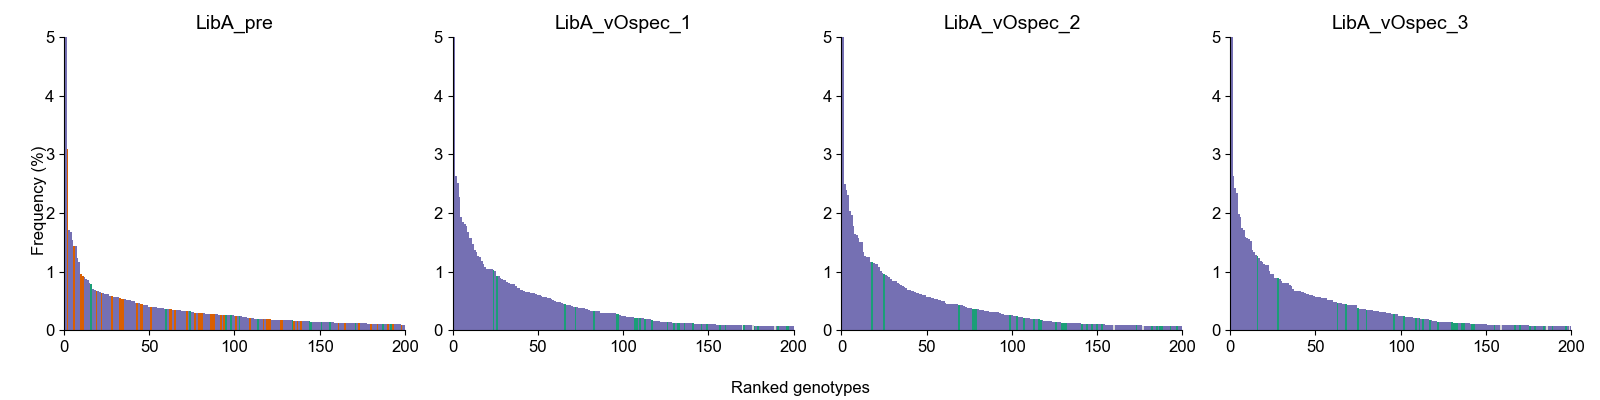

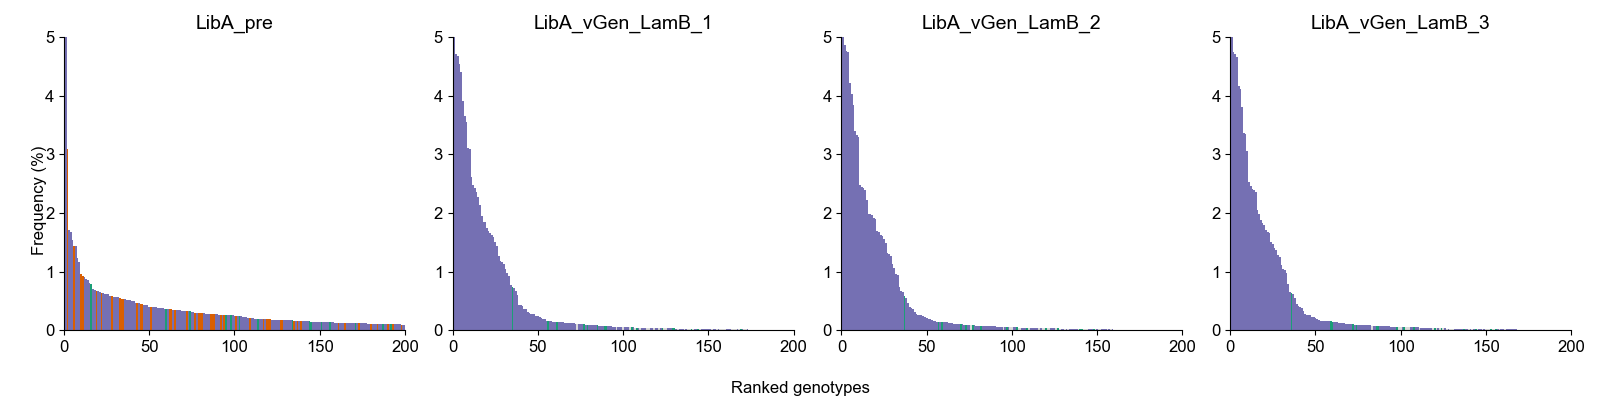

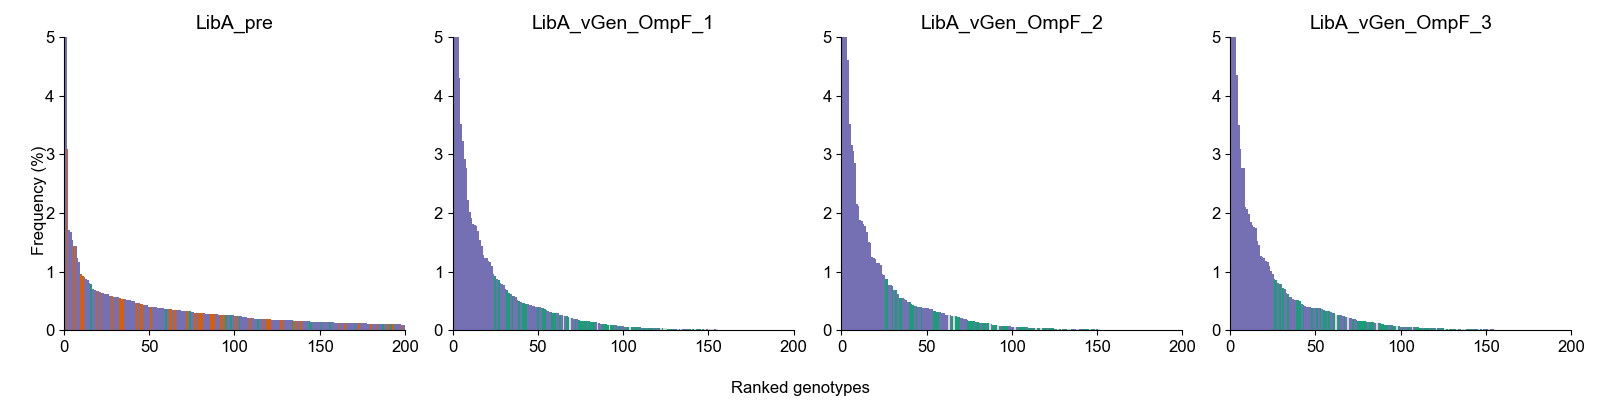

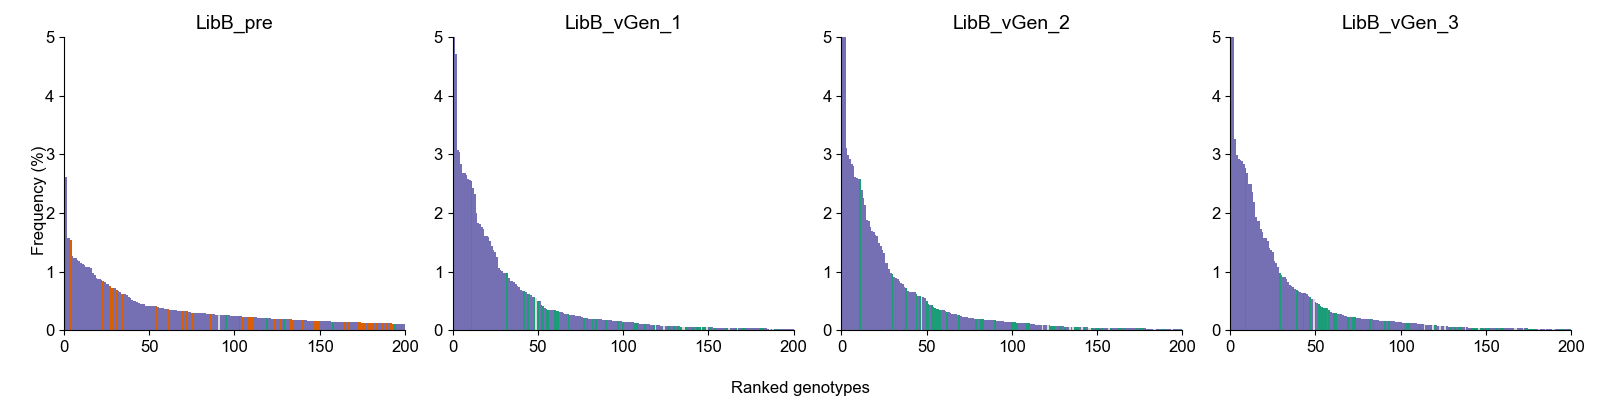

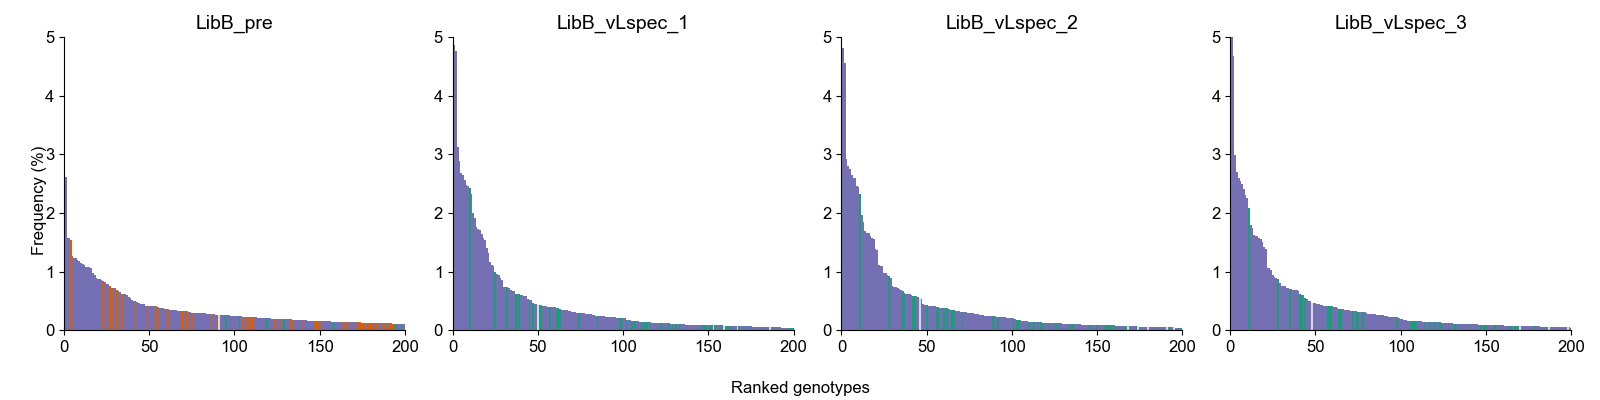

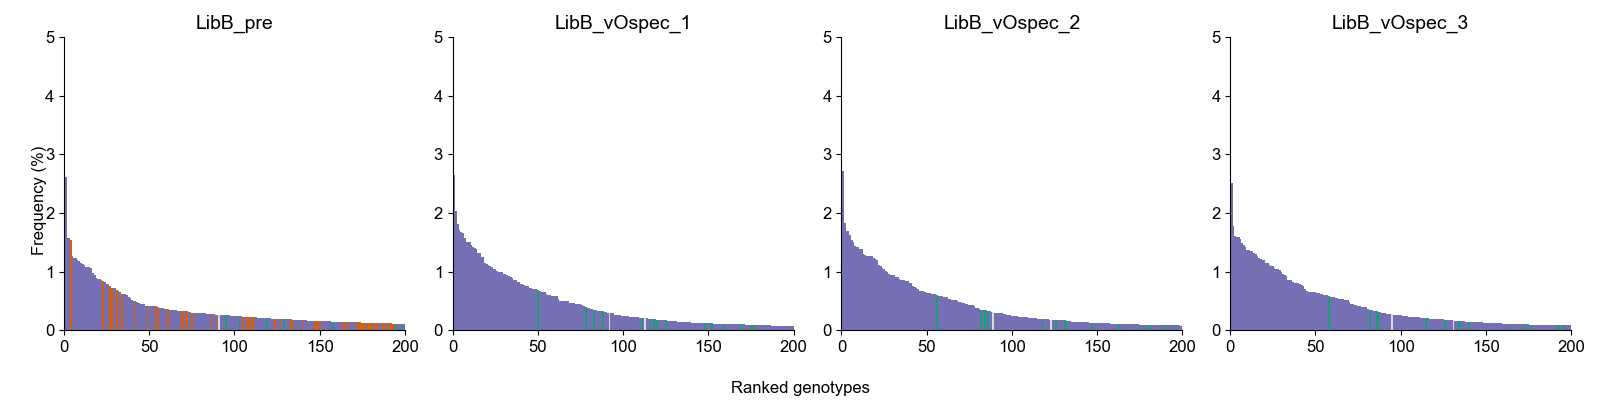

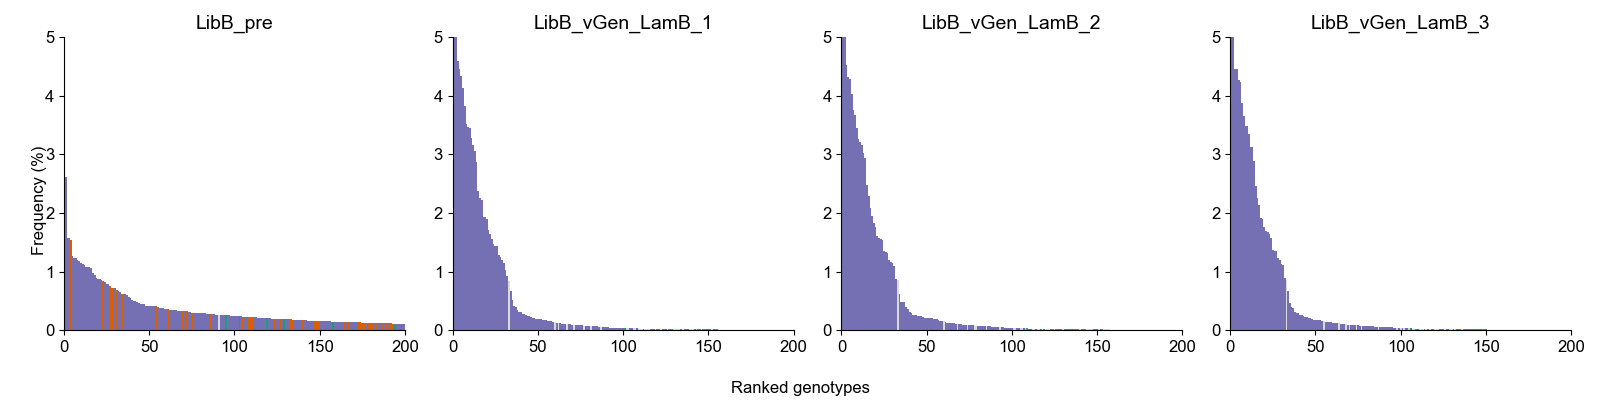

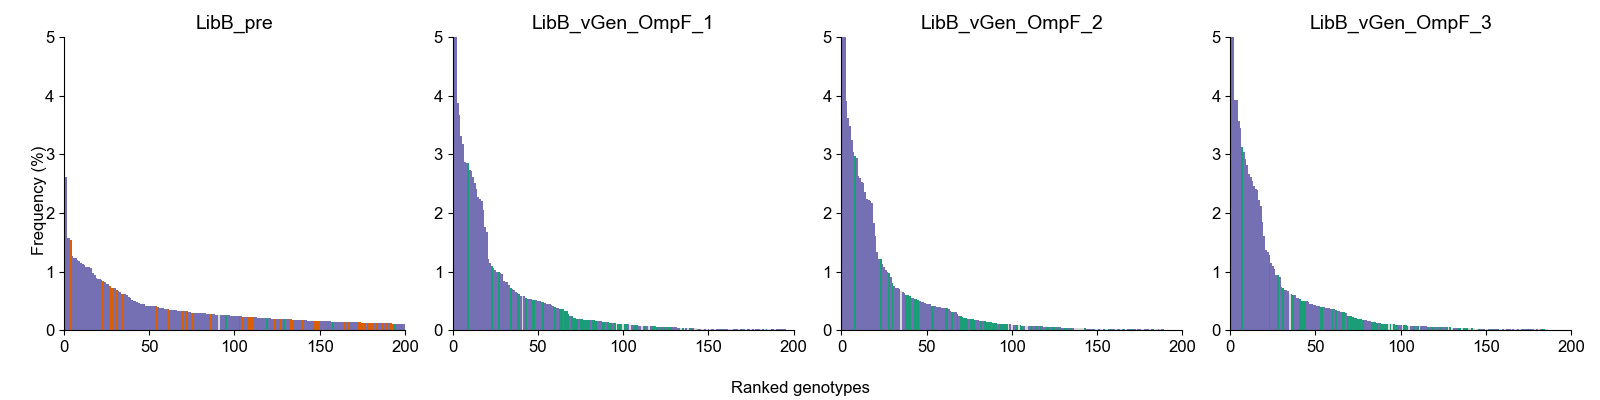

In [38]:
for lib in ['A','B']:
    for env in ['Gen', 'Lspec', 'Ospec', 'Gen_LamB', 'Gen_OmpF']:
        this_id = 'Lib%s_v%s' % (lib, env)
        sample_list = 'Lib%s_pre %s_1 %s_2 %s_3' % (lib, this_id, this_id, this_id)
        command = "python scripts/plot_genotypesampling.py %s %s 1 4 --nplots 4 --ylim 5 --xlim 200 --plotfileprefix %s" % (outputpath, sample_list, this_id)
        subprocess.call(command, shell=True)
        display(Image('./output-notebook/genotypecounts/rankorderplots/prog-stop-LF/linear/genotypesampling-%s-linear.png' % this_id))

The above plots show genotype frequencies (y-axis, capped at 5% for comparison across all samples but note some samples have some genotypes at higher frequencies), in order of most abundant genotypes (ordered along x-axis). Each bar (representing a genotype) is colored according to: 
- purple (programmed genotypes of the combinatorial library)
- red (stop codon genotypes, which are the result of only partial recombination during MAGE and do not produce infectious virus due to the remaining stop codon in J)
- teal (c3283t containing genotypes - these contain a mutation that was presumed to be present in the parental strains used for MAGE at some appreciable frequency but was not intended to be part of the genotype library as it is not one of the 9 mutation sites; these are discussed some more below but ultimately discarded for all of the main analyses)
- grey (genotypes containing other additional mutations)

The plots above show how the *pre-competition* mutant virus library (first column) still contains many stop-codon containing genotypes due to incomplete purifying selection during the generation of the virus libraries. Columns 2-4 show three replicate flasks of a competition experiment; after the competition experiment we observe strong purifying selection against stop codon containing genotypes (as expected) and we also see that the most abundant genotypes are genotypes that are part of the programmed combinatorial library. c3283t and other genotypes are less frequently observed.

## Computing fitness measurements from genotype frequencies

`calc_sr.py` calculates selection rates (a measure of fitness) for all of the competition samples by examing changes in genotype frequencies between the *pre-competition* and *post-competition* samples. We will first run it with `--includeunprogrammed` to examine selection rates of all genotypes observed in the deep sequencing (not just the expected 512 combinations of mutations at the 9 programmed mutation sites). We found that there are a collection of genotypes with a mutation which was not part of the programmed library, `c3283t`, which introduces a L->F mutation in the J reactive region. Since this mutation is also observed in combination with the stop codon in the parental strain used for MAGE (see this data in the relevant `counts.csv` files), we infer that this mutation existed at some frequency before mutagenesis. We make some summary plots using `analyze_c3283t.py` showing that selection rates with vs. without this mutation across genotypes are generally correlated (viewable at `./output-notebook/selectionrate/c3283t.pdf`), but for the remainder of the analysis we will limit analyses to genotypes that were explicitly programmed with MAGE as part of the N=512 combinatorial library, since we know from plots above that all 512 genotypes were nearly uniformly included in the lysogen libraries.

In [ ]:
command = "python scripts/calc_sr.py %s --includeunprogrammed 1\n" % outputpath
print("calling command:\n%s" % command)
subprocess.call(command, shell=True)

command = "python scripts/analyze_c3283t.py %s %s\n" % (sr_files_path, sr_path)
print("calling command:\n%s" % command)
subprocess.call(command, shell=True)

command = "python scripts/calc_sr.py %s \n" % outputpath
print("calling command:\n%s" % command)
subprocess.call(command, shell=True)

#### How reproducible are the measurements of fitness from the library competition experiments?

Next we will look at correlations in the measured selection rates. Correlations plots are scatter plots of the measured selection rate between two datasets, and Pearson's R is computed across all genotypes that have a selection rate measured in both datasets. Some genotypes are only observed in one dataset and are plotted arbitrarily at -10 when not observed in a dataset. The plots are made by `plot_srcorr_subplots`.

We will look at the correlations between replicate competition flasks (three replicates were performed for each library) and between biological replicate libraries (two independently generated libraries; we will use the averages across each library to examine library-library correlation). `merge_srdata.py` computes the average selection rates across multiple datasets.

In [ ]:
lib_comps = ['LibA_vGen',
                'LibA_vGen_LamB',
                'LibA_vGen_OmpF',
                'LibA_vLspec',
                'LibA_vOspec',
                'LibB_vGen',
                'LibB_vGen_LamB',
                'LibB_vGen_OmpF',
                'LibB_vLspec',
                'LibB_vOspec' ] 

for lib_comp in lib_comps:
    merged_file = str(sr_files_path) + '/sr_' + lib_comp + '_avg.csv' # name of output file after merging
    replicates_files = [str(sr_files_path) + '/sr_' + lib_comp + '_%s.csv' % i for i in [1,2,3]]
    replicates_files_liststring = ' '.join(replicates_files)
    
    command = "python ./scripts/merge_srdata.py --mergedfile %s --srfiles %s\n" % (merged_file,replicates_files_liststring) 
    subprocess.call(command, shell=True)

In [ ]:
command = "python ./scripts/plot_srcorr_subplots.py %s %s\n" % (str(sr_files_path), str(sr_path))
subprocess.call(command, shell=True)

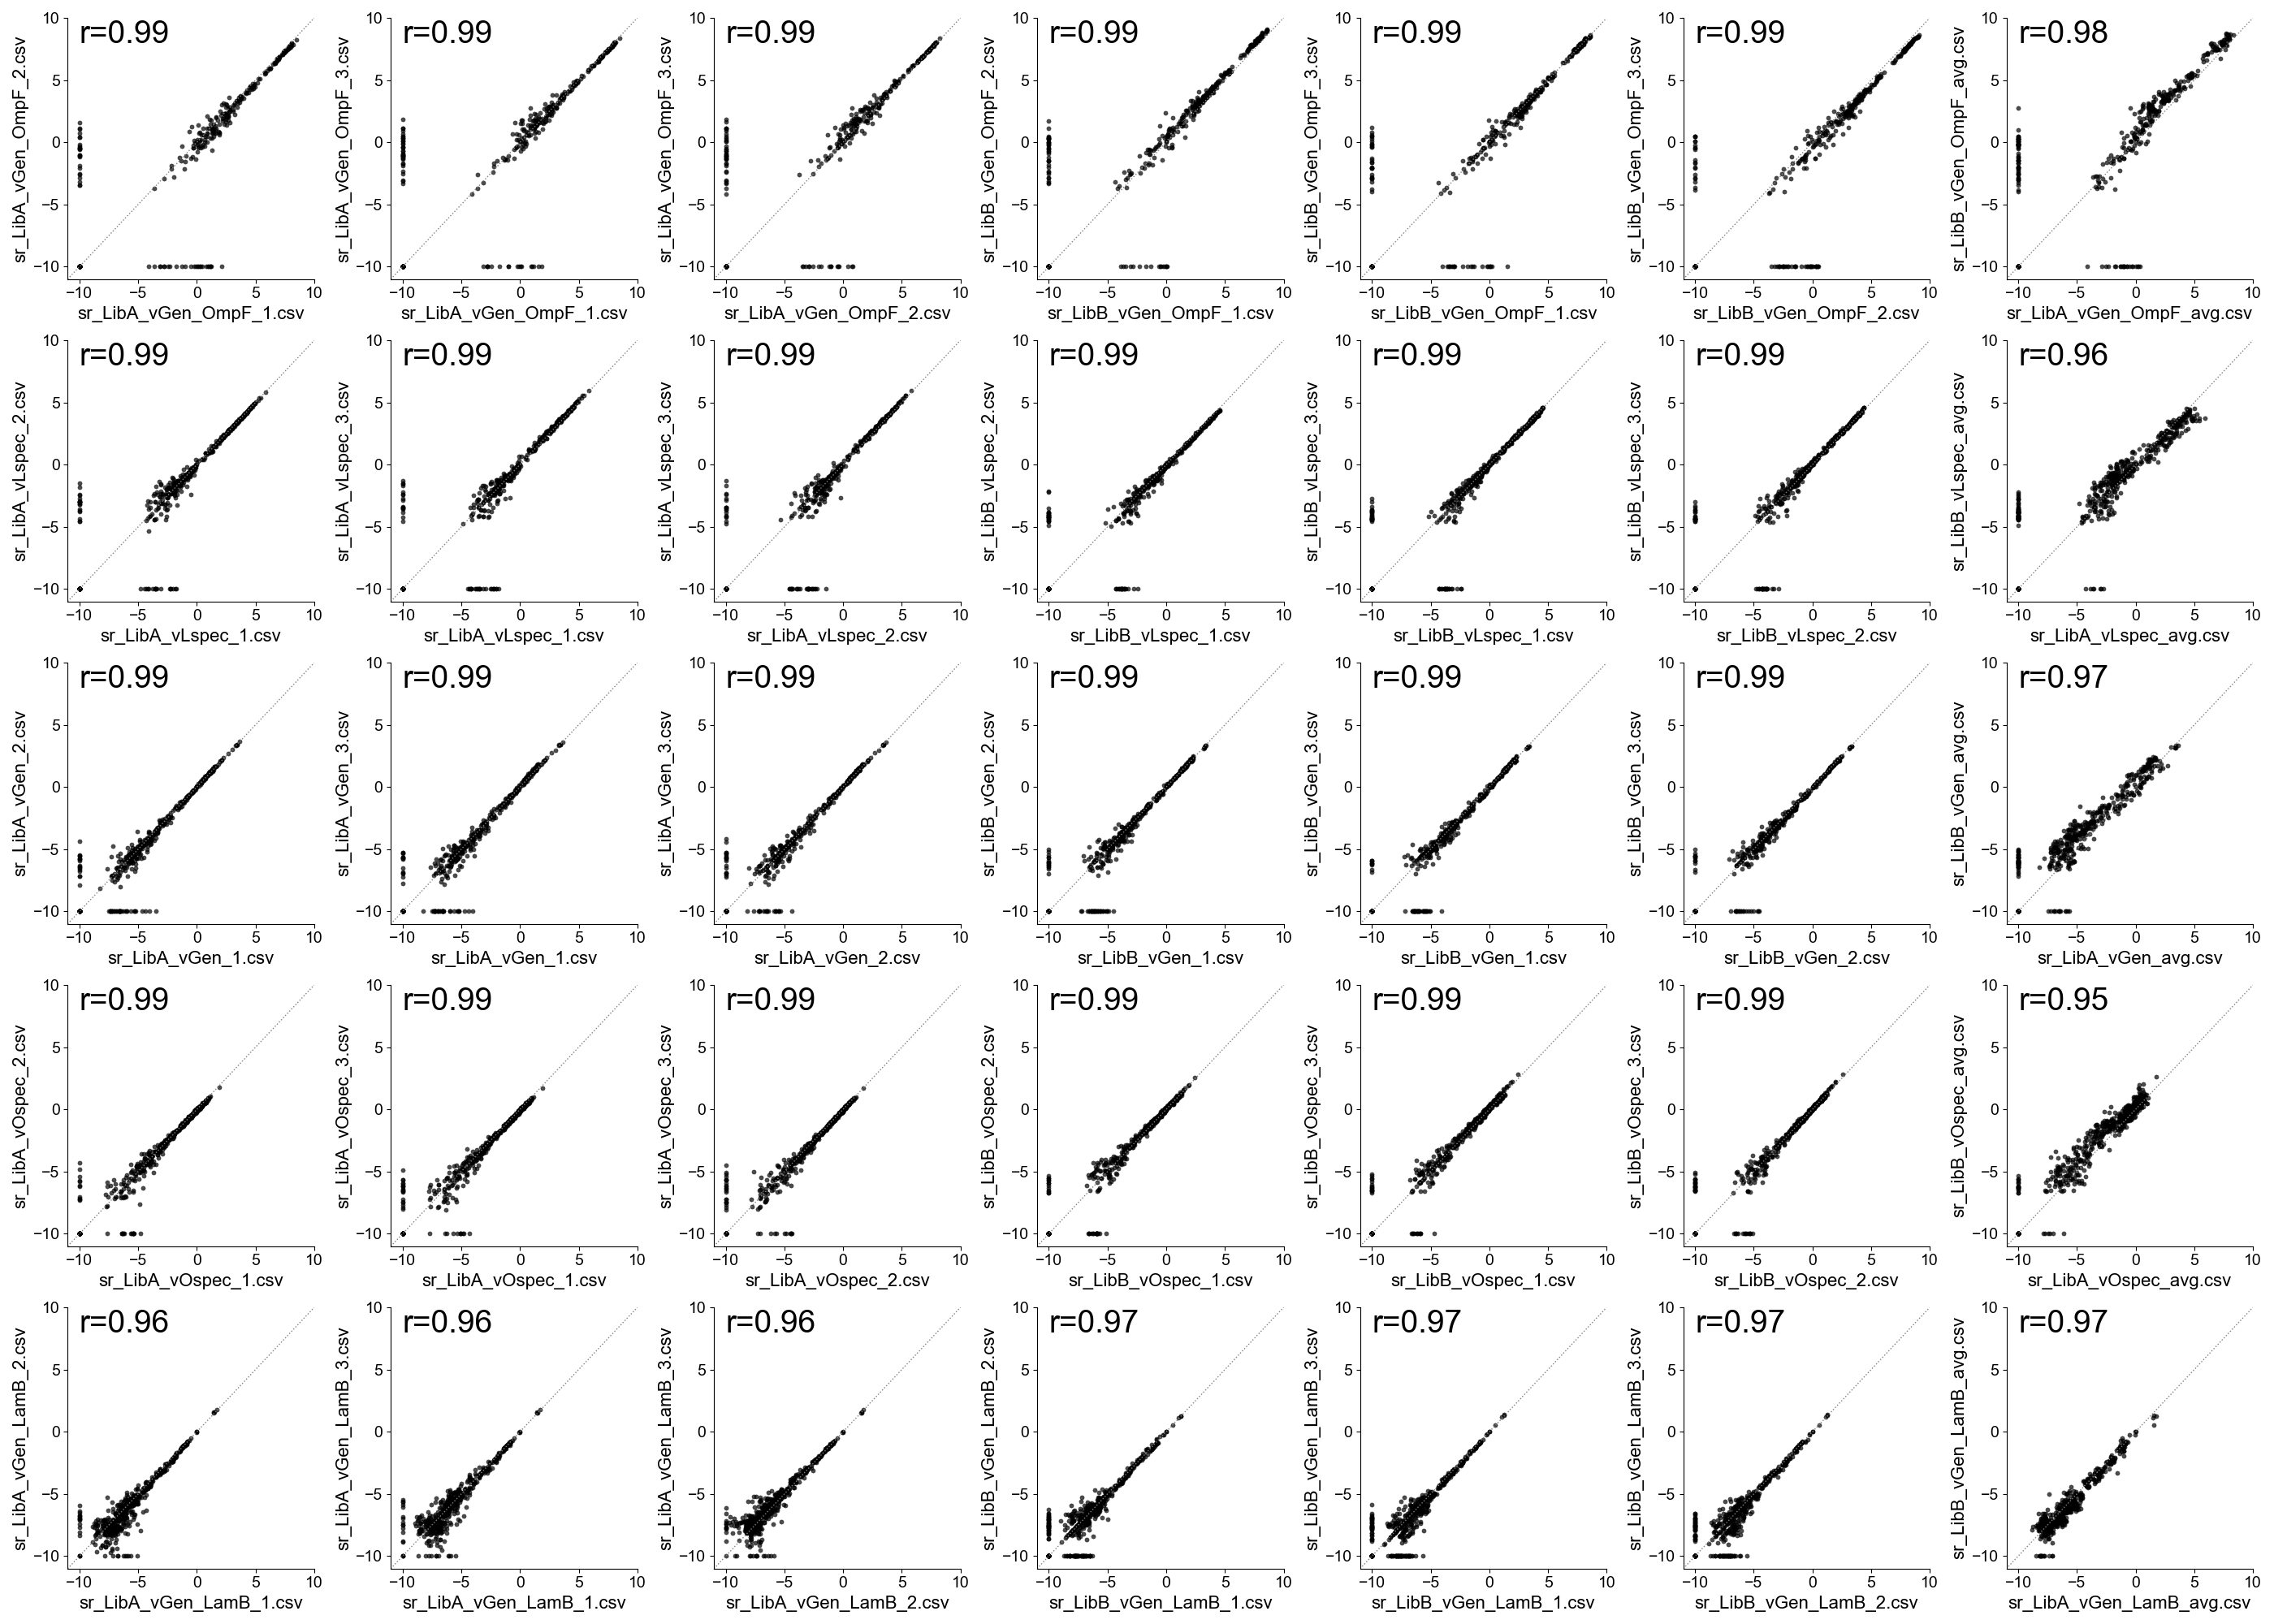

In [6]:
display(Image(str(sr_path) + '/sr-correlations.png', width=900))

The selection rate measurements are highly correlated across replicate competition flasks and also across the two biological replicate virus libraries. It appears there is more experimental noise between replicate libraries than between replicate competition flasks using the same library. 

For the rest of the analyses we will use selection rates that are averaged across both libraries (designated with the `LibAvg` file name prefix), these are effectively average fitness measurements across 6 replicate experiments:

In [33]:
comps = ['vGen',
        'vGen_LamB',
        'vGen_OmpF',
        'vLspec',
        'vOspec']
for comp in comps:
    lib_a_files = [str(sr_files_path) + '/sr_LibA_' + comp + '_%s.csv' % i for i in [1,2,3]]
    lib_b_files = [str(sr_files_path) + '/sr_LibB_' + comp + '_%s.csv' % i for i in [1,2,3]]
    replicates_files_liststring = ' '.join(lib_a_files) + ' ' + ' '.join(lib_b_files)
    merged_file = str(sr_files_path) + '/sr_LibAvg_' + comp + '.csv'
    command = "python ./scripts/merge_srdata.py --mergedfile %s --srfiles %s\n" % (merged_file, replicates_files_liststring)
    subprocess.call(command, shell=True)

## Computing the specialization index for every genotype

Using fitness measurements from competition flasks using host cells *only* expressing LamB or OmpF (i.e, fitness measurements purely on LamB or purely on OmpF), `parse_specialists.py` computes a *specialization index* for each genotype.


Identifying specialist genotypes using arguments:
Namespace(selectionrateonL='output-notebook/selectionrate/srfiles/sr_LibAvg_vGen_LamB.csv', selectionrateonO='output-notebook/selectionrate/srfiles/sr_LibAvg_vGen_OmpF.csv', specialistdir='output-notebook/selectionrate/specialists')

Using selection rate data from files:
Sr on L:output-notebook/selectionrate/srfiles/sr_LibAvg_vGen_LamB.csv
Sr on O:output-notebook/selectionrate/srfiles/sr_LibAvg_vGen_OmpF.csv
Saving results to output-notebook/selectionrate/specialists


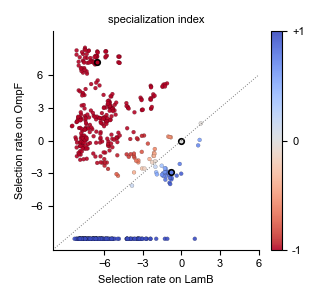

In [4]:
sr_on_l_file = str(sr_files_path) + '/sr_LibAvg_vGen_LamB.csv'
sr_on_o_file = str(sr_files_path) + '/sr_LibAvg_vGen_OmpF.csv'
command = "python ./scripts/parse_specialists.py %s %s %s\n" % (sr_on_l_file, sr_on_o_file, str(specialists_path))
subprocess.call(command, shell=True)
display(Image(str(specialists_path) + '/specialists.png'))

As expected, the genotypes corresponding to the O-specialist and L-specialist used as competitor viruses have strong specialization index values. It appears most genotypes are relatively specialized in one direction or the other. This quantitative measure of specialization *per genotype* will be useful in other analyses below.

## Analysis of hybrid genotypes derived from pairs of divergent specialists

The goal of this section is to see if genetic incompatabilities between divergent specialists might contribute to the diversification and speciation process. Based on a single observation from prior work where a single pair of specialists were analyzed (and the hybrid was unfit), we here hypothesized that genetic incompatabilities more generally might lead to decreases in fitness in genetic hybrids between parental specialists and examine this over many pairs of specialist genotypes.

In [44]:
command = "python ./scripts/analyze_hybrids.py %s %s\n" % (str(sr_files_path), str(specialists_path))
subprocess.call(command, shell=True)

There are 190 L specialists and 314 O specialists

there are 27 L-specialists that have a measured selection rate on OmpF
there are 314 O-specialists that have a measured selection rate on LamB
Analyzing 27 Ls and 27 O sp
{'total': 729, 'redundant_hybrid_is_Lsp': 0, 'redundant_hybrid_is_Osp': 63, 'spec_nan': 0, 'hybrid_nan_on_either': 130, 'hybrid_nan_on_L': 0, 'hybrid_nan_on_O': 130, 'hybrid_nan_on_both': 0, 'hybrid_nan_is_Lspec': 130, 'hybrid_nan_is_Ospec': 0, 'triad_analyzed': 536, 'hybrid_is_Lsp': 0, 'hybrid_is_Osp': 536}


0

Based on the results above, when analyzing all 729 pairs of the 27 most-specialized L- and O- specialists, 130 of the resulting hybrid genotypes did not have an observed fitness on OmpF (thus are some sort of L-specialist), and 63 of the hybrid genotypes were the same genotype as the O-specialist (meaning that the L-specialist genotype was strictly a subset of the mutations in the O-specialist genotype). After removing these genotypes, there were remaining 536 triads of (L-specialist genotype, O-specialist genotype, hybrid genotype) where all three genotypes had measured fitness on both receptors in order to compute changes in hybrid fitness from expected based on the parental specialists. Notably, all 536 of these triads resulted in a hybrid that was an O-specialist.

Below for reference are plots showing 1) the 27 L-specialists and 27 O-specialists used in the analysis, and 2) the change in fitness on each receptor of the hybrid genotype compared to the average of the parental genotypes.

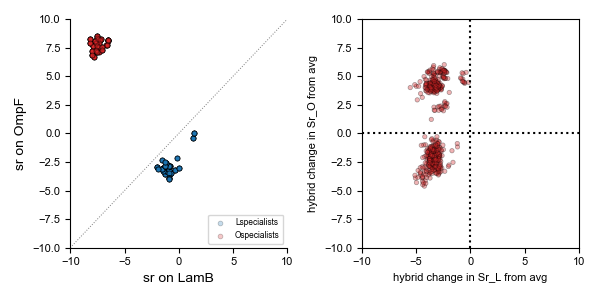

In [45]:
display(Image(str(specialists_path) + '/hybridsummary.png'))

To summarize the change in overall fitness (i.e, over both receptors), we use a geometric interpretation of the change in fitness from the specialist average. A line is drawn between the two specialist genotypes representing commensurate increases in fitness on one receptor corresponding to decreases on the other; points along this line are considered to have overall fitness change of 0 relative to the average of the specialists. For the hybrid genotype, an orthogonal vector is drawn from the above line to the hybrid genotype; the magnitude of this vector represents the overall hybrid change in fitness from the specialist average (e.g, if the hybrid is below/left of this line, it is less fit than the average of the specialists; if the hybrid is above/right of this line, it is more fit than the average of the specialists. 

Below we plot the distribution of the magnitude of this vector across the 536 triads analyzed, showing that hybrid genotypes tend to be overall less fit than the average of the parental specialists:

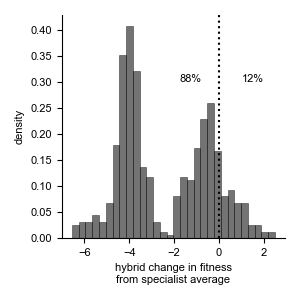

In [46]:
display(Image(str(specialists_path) + '/hybrid_change_in_fitness.png'))

## Analysis of pleiotropic effects of single mutations

For any single mutation between two genotypes in the library, what is the effect of that mutation on the fitness on each receptor? What are the distributions of these effects over all of the possible mutations? These distributions are plotted below:

In [ ]:
command = "python ./scripts/plot_pleiotropy.py %s %s\n" % (str(sr_files_path), str(specialists_path))
subprocess.call(command, shell=True)

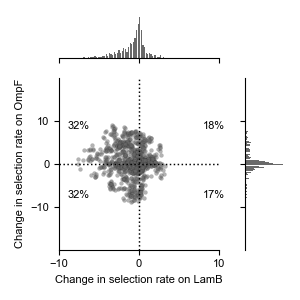

In [7]:
display(Image(str(specialists_path) + '/pleiotropy.png'))

Here we see the distribution of mutation effects across all single mutations from one genotype in the library to another (conditioning on both genotypes having a measured fitness on each receptor; this limits the analysis to 1277 out of a total possible 2304 data points, where each point represents a mutation between two genotypes). Only mutations at any site from the ancestral (EvoC) nucleotide at that site to the derived nucleotide are included (as opposed to the reversions of these mutations), so in a sense this is showing the effets of mutations moving in the "forward" direction of the evolutionary trajectory from generalist into two specialists.

When considering the effects of these mutations on the ability of the virus to use the native receptor LamB, we see that the distribution of mutation effects is shifted leftwards (negative fitness change on LamB): the average mutation decreases fitness on LamB. In contrast, the distribution of mutation effects on OmpF fitness is symmetric around 0.

## Visualization of fitness landscapes

We visualize fitness landscapes as plots of networks of connected genotypes; each node is a genotype and nodes are connected by edges when they are a single mutation away from eachother in genotype space. We separate genotypes on the x-axis by the hamming distance to the ancestor EvoC sequence (i.e, the number of mutations in the genotype relative to the starting sequence). We color the genotypes based on the specialization index. Below we generate these plots and show the fitness landscapes across the five experimental environments tested (with respect to changes in the competitor virus strain and the host cells available for infection).

In [ ]:
# Visualize the fitness landscapes on network plots showing fitness for genotypes by hamming distance from ancestor and edges connecting neighboring genotypes
plot_dir = '%s/selectionrate/networkplots/' % (str(outputpath))

runname = 'no_highlight' # first make landscape plots without highlighting genotypes by specialization index
command = "python ./scripts/networksubplots.py %s %s %s\n" % (str(sr_files_path), plot_dir, runname)
subprocess.call(command, shell=True)

runname = 'highlight_si' # also Make fitness landscape network plots coloring each genotype point by specialization index
colordatafiles = ' '.join(['%s/si.csv' % str(specialists_path)])
command = "python ./scripts/networksubplots.py %s %s %s --colortype quantitative --colordatafiles %s\n" % (str(sr_files_path), plot_dir, runname, colordatafiles)
subprocess.call(command, shell=True)

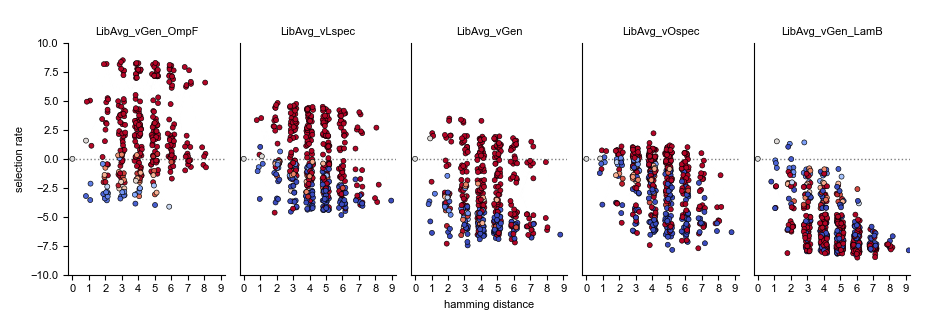

In [6]:
plot_dir = '%s/selectionrate/networkplots/' % (str(outputpath))
display(Image(plot_dir + '/highlight_si/five_environments_squish_subplt-by-highlight_si.png'))

For some reason the `*.png` format here in the notebook isn't showing the edges between nodes, but the `*.pdf` version does. The main finding here is that there are large changes in the fitness landscapes that are immediately visually apparent: The O-specialist genotypes dominate a fitness plateau in the first several landscapes, however, this effect is diminished in competition with an O-specialist virus or in an environment where OmpF+ cells are not available, congruent with expectations.

## Multiple linear regression

We will use linear regression to examine for statistical evidence epistasis between mutation sites and between mutation sites and the nature of the competitor virus that shapes the shifts in fitness landscapes across environments.  Before performing the regression analyses, first we will show that mutations at sites 2 and 3 can be consolidated into a single term for the purposes of simplifying the regression model.

The 2nd and 3rd mutation both introduce the same amino-acid change to the same codon; furthermore the combination of muations (2+3) also result in the same amino-acid change to that codon. Thus, we examine correlations in fitness among these synonymous genotypes and find that, as expected, they are very highly correlated (see below). Based on these results, we will simplify the terms of the regression model so that there is a single term (`G2/3`) representing either mutation 2 or 3 or 2+3. 

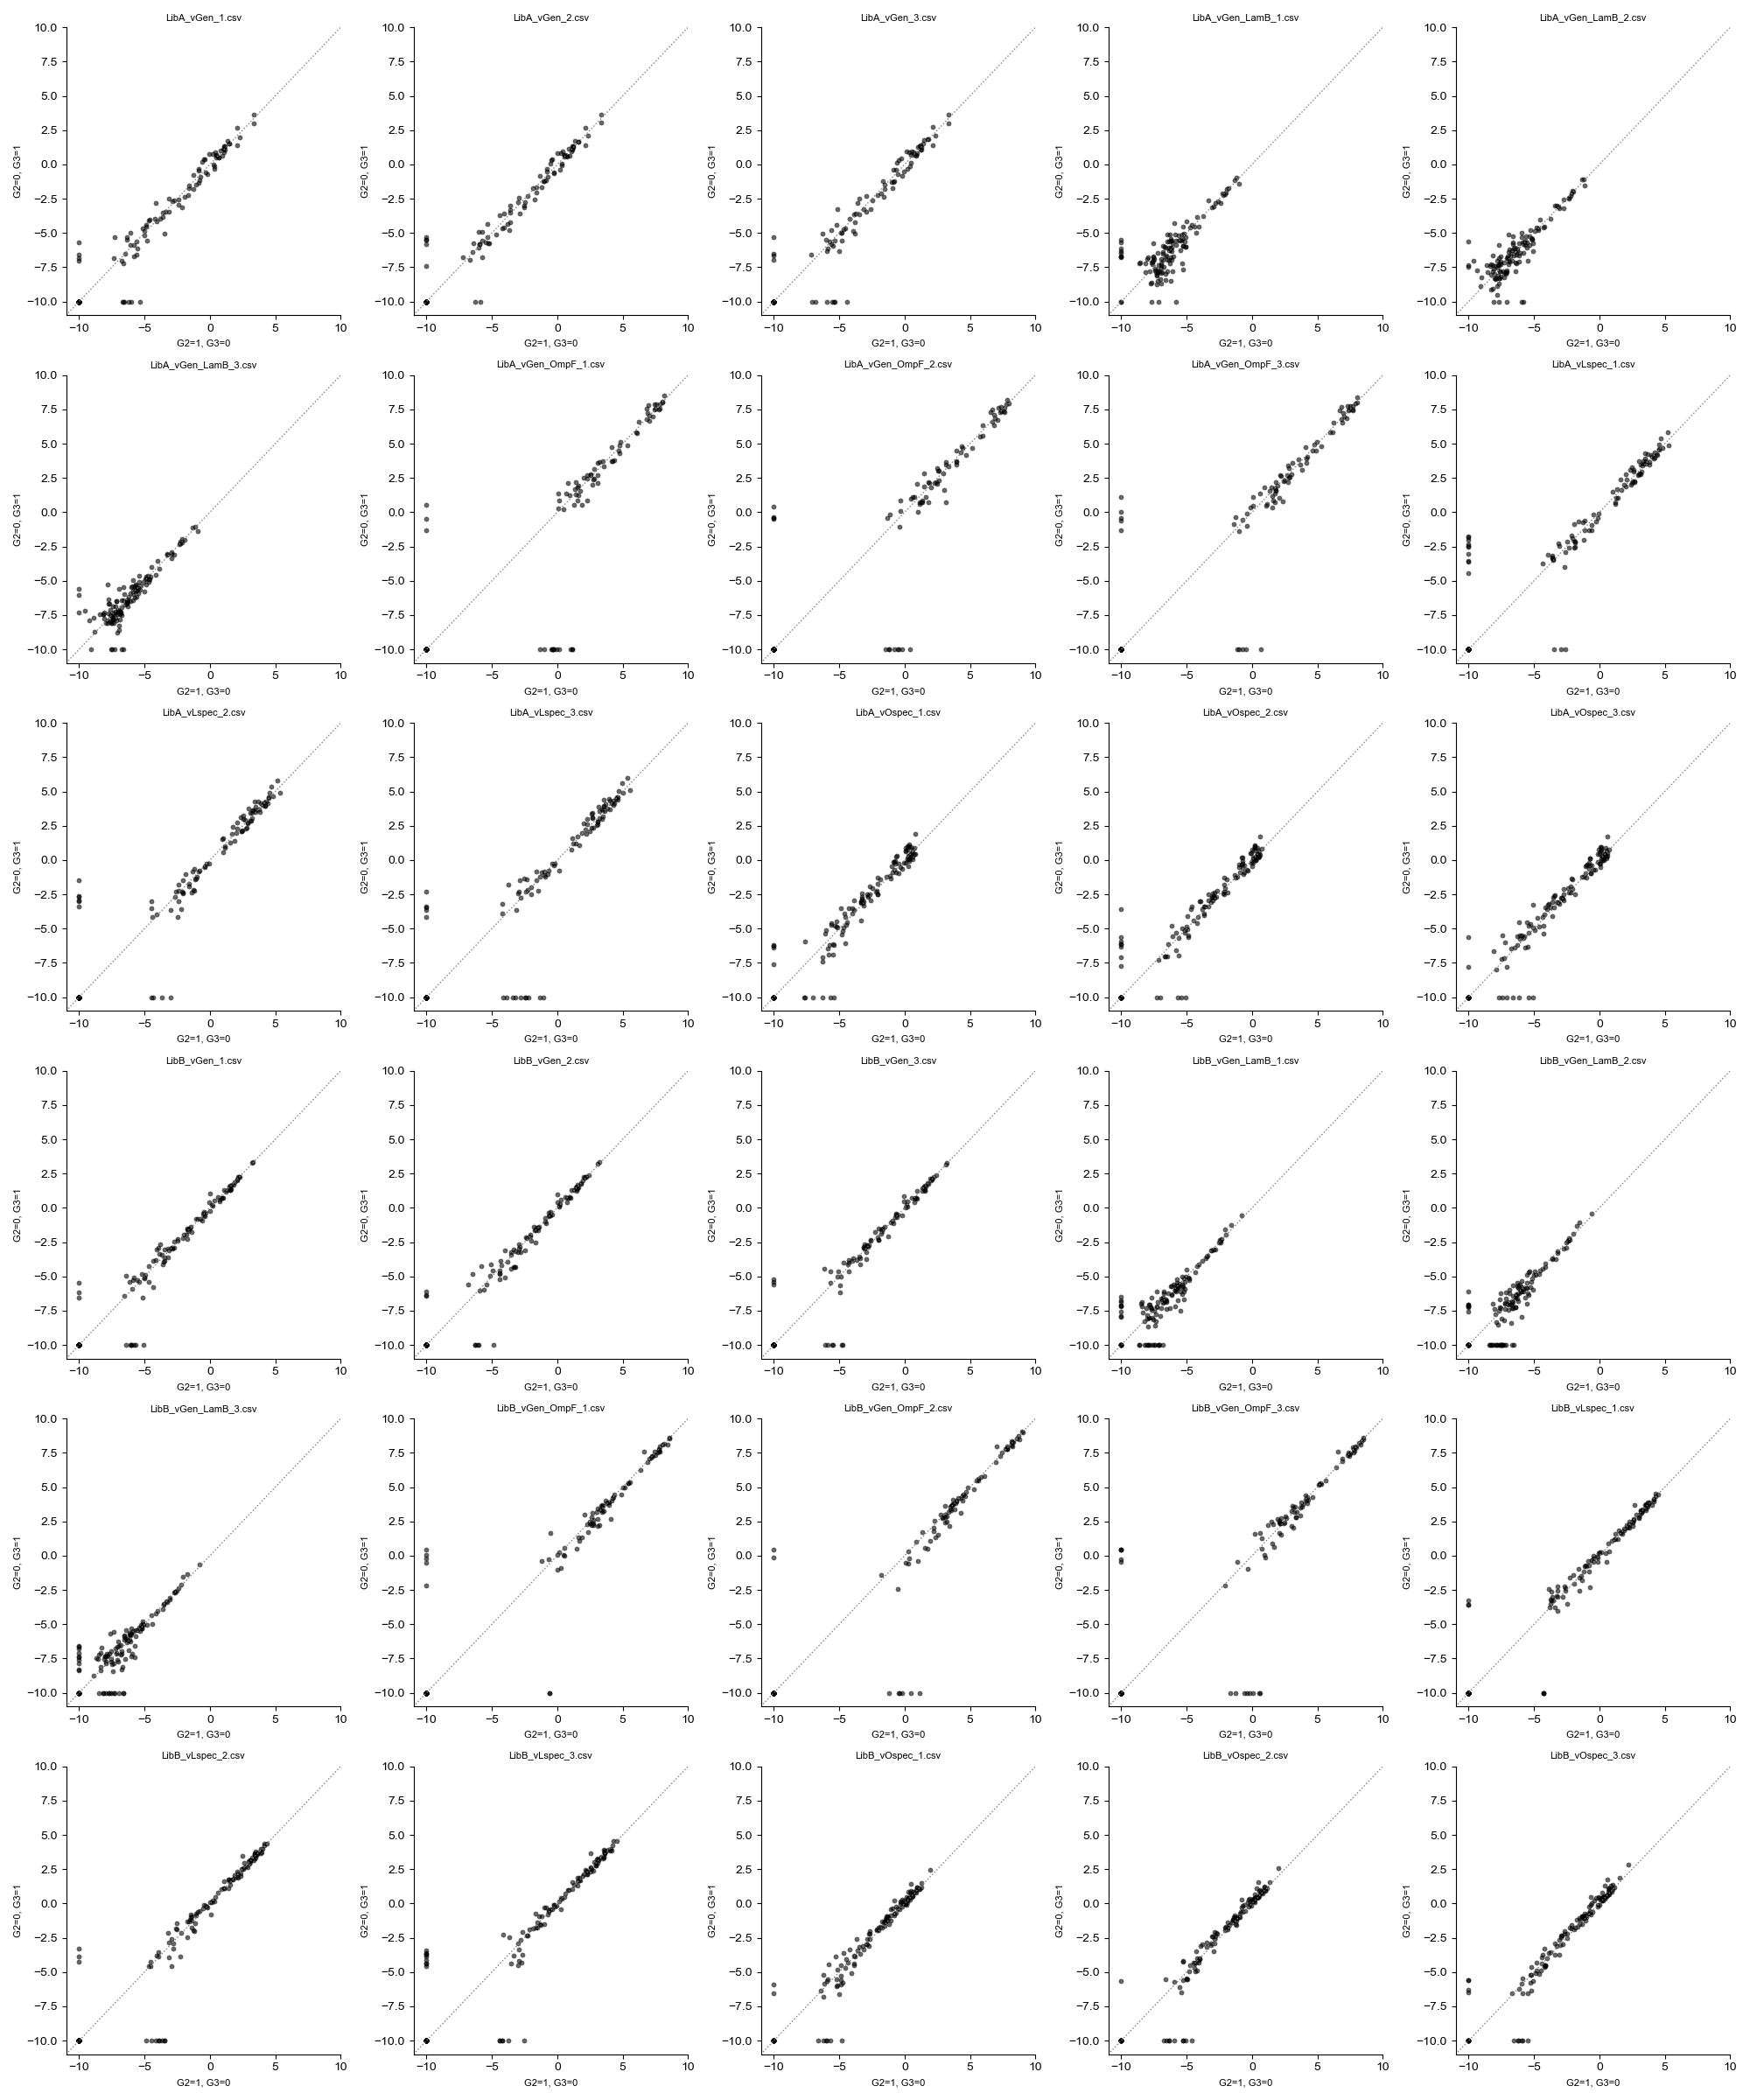

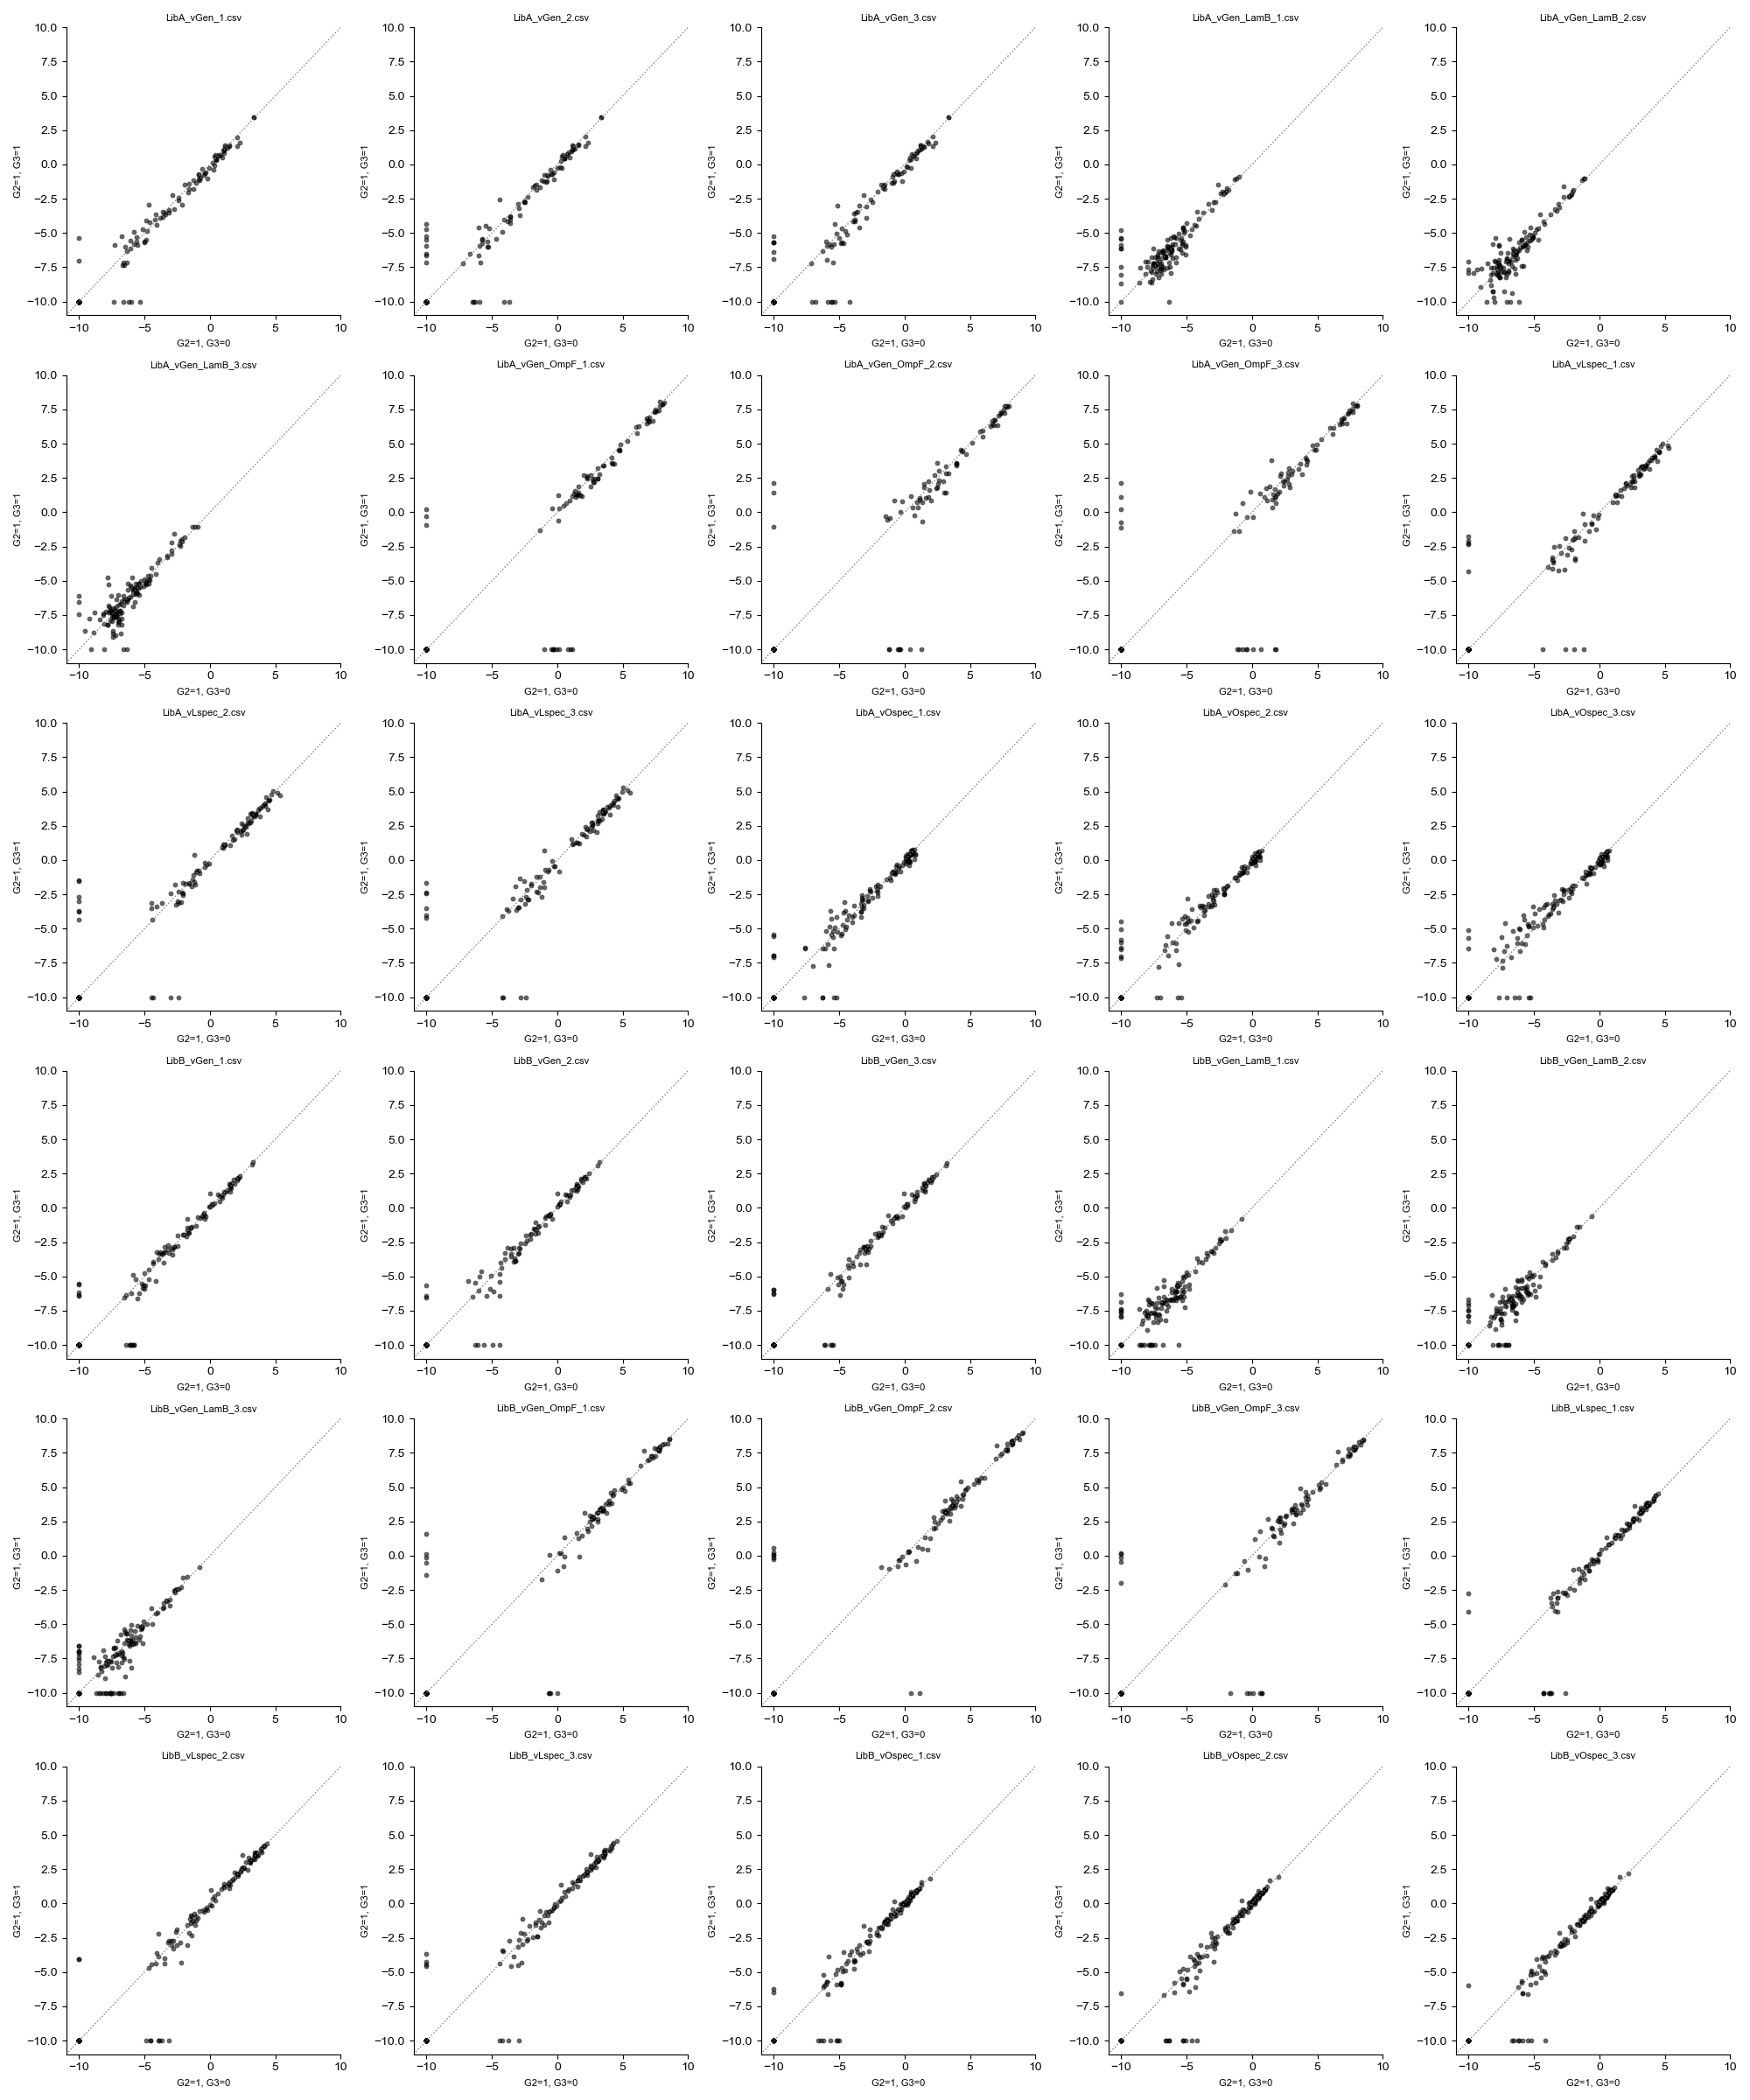

In [59]:
command = "python ./scripts/analyze_g23r.py %s %s\n" % (str(sr_files_path), str(sr_path))
subprocess.call(command, shell=True)

display(Image(str(outputpath) + '/selectionrate/g2g3.png'))
display(Image(str(outputpath) + '/selectionrate/g2g23.png'))


Now we will perform multiple linear regression (implemented in the script `mlr.py`) on the samples that were competed in the MIXED HOSTS (LamB knockout cells + OmpF knockout cells) environments. To avoid overly complicating the model, we will omit fitness measurements made on single hosts (LamB or OmpF alone).

In [ ]:
samples_mixedhost = [
            'LibA_vGen_1',
            'LibA_vGen_2',
            'LibA_vGen_3',
            'LibA_vLspec_1',
            'LibA_vLspec_2',
            'LibA_vLspec_3',
            'LibA_vOspec_1',
            'LibA_vOspec_2',
            'LibA_vOspec_3',
            'LibB_vGen_1',
            'LibB_vGen_2',
            'LibB_vGen_3',
            'LibB_vLspec_1',
            'LibB_vLspec_2',
            'LibB_vLspec_3',
            'LibB_vOspec_1',
            'LibB_vOspec_2',
            'LibB_vOspec_3' ]
sample_id_stringed = ' '.join(samples_mixedhost) 

command = "python ./scripts/mlr.py %s %s %s\n" % (str(outputpath), 'mlr-allmixedhostsamples', sample_id_stringed)
subprocess.call(command, shell=True)

`mlr_summary_fig.py` generates the heatmap figure from the LASSO regression results.

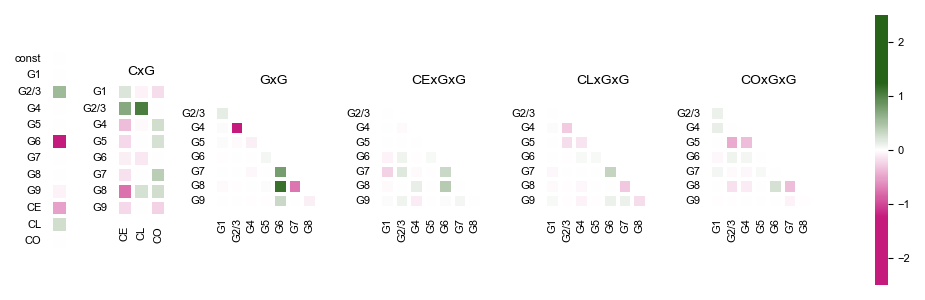

In [62]:
command = "python ./scripts/mlr_summary_fig.py %s %s\n" % (str(outputpath), "mlr-allmixedhostsamples")
subprocess.call(command, shell=True)
display(Image(str(outputpath) + '/selectionrate/regression/mlr-allmixedhostsamples/lasso-AIC-coefs_coefs_summary.png'))

Many coefficients in the model predicting fitness from genotype and competitor are reduced to zero, as is the idea behind LASSO regression, and among the remaining coefficients we can see here that among the strongest predictors are some individual mutations (e.g., G6 strongly negative), some competitor-dependent effects of individual mutations (e.g., G8 uniquely negative in setting of generalist competitor "CE"; G2/3 uniquely positive in generalist or L-specialist competitors); and some competitor-independent pairwise epistasis terms (e.g., G4xG2/3; G6x G7-G9). Interestingly there are many weaker signals of competitor-dependent pairwise epistasis within the CxGxG blocks.

## Simulations of lambda evolution using experimentally-measured fitness landscapes

We will use the experimentally-measured fitness landscapes as a basis for modeling lambda evolution using computer simulations. The main goal of these simulations is to examine the implications of the dynamic fitness landscapes we measured with the mutant virus library experiments on the phenotypic diversification we have previously seen in experimental evolution of the receptor generalist into coexisiting receptor specialists.

### The simulation model

The simulation code uses a modified Wright-Fisher model (implemented in `wfm.py`) to simulate **500 generations** of simulated evolution of a fixed population size of lambda viruses, starting as a homogenous population of the ancestral/unmutated/generalist EvoC sequence. At each generation there is opporunity for random mutation at any of the 9 sites in the combinatorial genotype space. Reproduction sucess rates are based on experimentally-measured fitness landscapes. 

We test the hypothesis that continuous shifts in the fitness landscape induced by competition with emerging viral genotypes allows for diversification by comparing models using either static of continuously shifting fitness landscapes. In the continuously shifting models, the landscape governing reproduction at any given generation is interpolated from experimental landscapes measured across multiple environments. **500 replicate simulations** are run for each landscape model, and we can analyze changes in the genetic and phenotypic diversity of the viruses between the various model types.

In [ ]:
landscapes = ['vEvoC-onlyOmpF', 'vLspec-mixed', 'vEvoC-mixed', 'vOspec-mixed', 'vEvoC-onlyLamB']
landscape_trajectories = ['continuous'] + ['static:%s' % l for l in landscapes]
starting_population = 'population-evoc.csv'
simsetname = 'sim-run-1' 
simulation_set_path = Path(str(sims_path) + '/' + simsetname)
simulation_set_path.mkdir(parents=True, exist_ok=True)

runnames = [] 
num_generations = 500
num_sims = 500
noise_per_sim = 0.6 # see notebook section below; this is tuned so that replicate simulations use landscapes as well correlated to eachother as the landscapes measured in replicate mutant libraries
nrows = 5 # for plotting abundance plots
ncols = 2 # for plotting abundance plots
assert num_sims >= nrows*ncols

for landscape_trajectory in landscape_trajectories:
    
    nickname_landscape = landscape_trajectory.replace(':','-')
    runname = simsetname + '-' + nickname_landscape 
    runnames.append(runname)
    
    command = 'python ./scripts/wfm.py %s %s %s --numgenerations %s --numsims %s --landscapetrajectory %s --noisepersim %s' % \
        (str(outputpath),
         simsetname,
         runname,
         num_generations,
         num_sims,
         landscape_trajectory,
         noise_per_sim)
    subprocess.call(command, shell=True)
    
    simdir = str(simulation_set_path) + '/' + runname
    command = 'python ./scripts/plot_simulation_abundances.py %s %s %s %s --legendtype multiple\n' % \
        (str(outputpath), 
         simdir, 
         nrows, 
         ncols)
    subprocess.call(command, shell=True)

**500 replicate simulations** were run for each landscape model, and now we can analyze the genetic and phenotypic diversity of the simulated virus populations. For example, here are population trajectories for a random collection of 10 simulations per model, for two simulation models: first, the continuous model, and second, the static model using the "middle" landscape (panel C of the main figure, vs. competitor EvoC on mixed host cells).

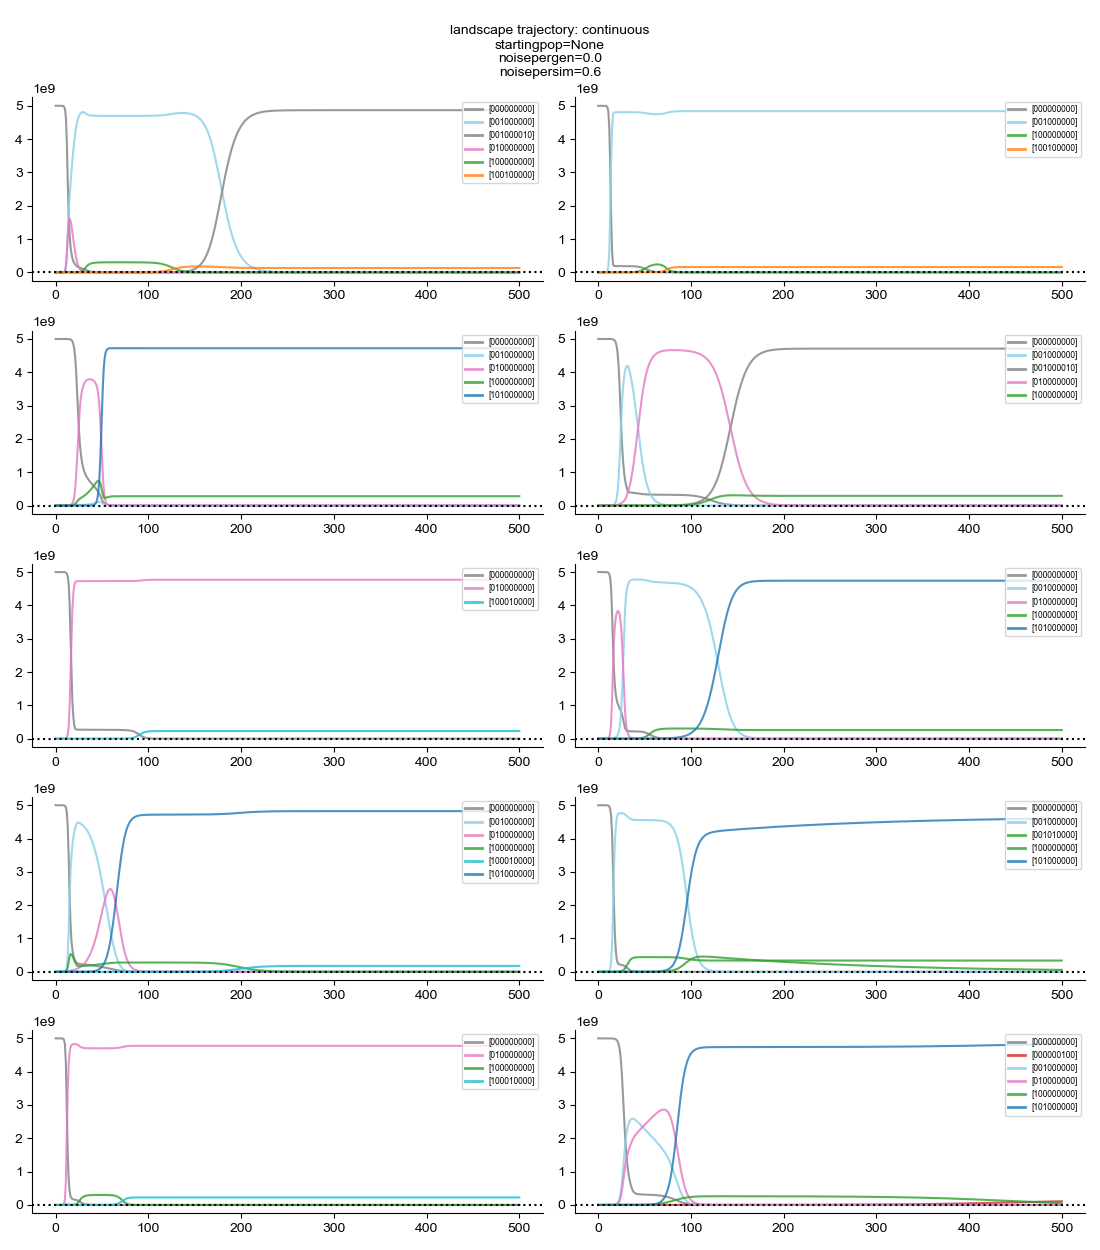

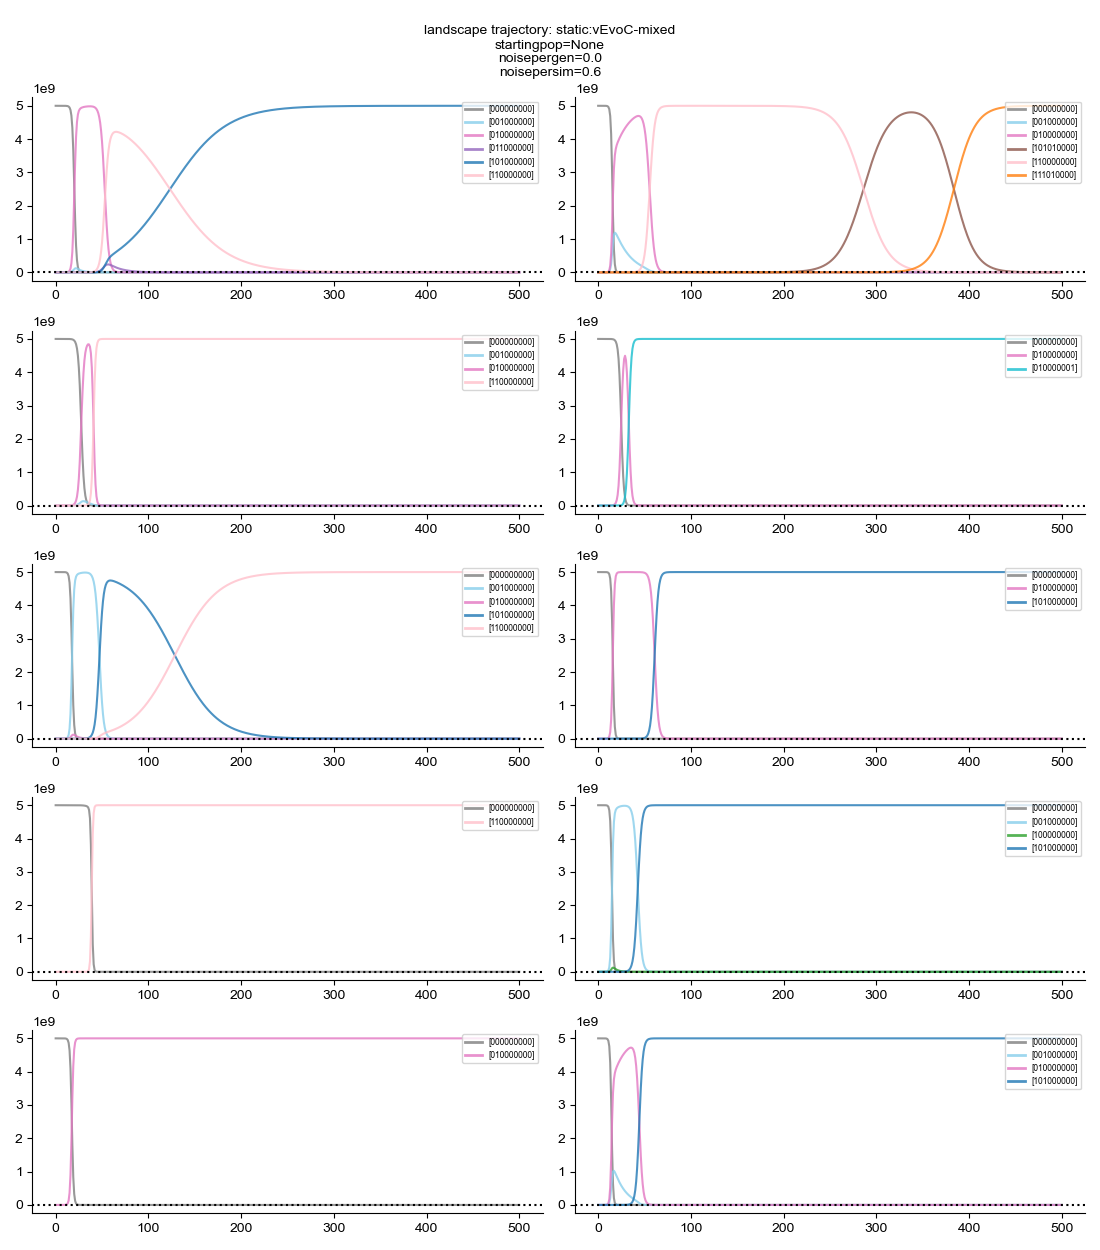

In [6]:
for runname in runnames[0:1] + runnames[3:4]:
    image = Image(str(simulation_set_path) + "/" + runname + '/customcolorcycle.png', width = 800)
    display(image)

Each virus genotype is assigned a random color to help see that due to the inherent stochasticity of simulated evolution, a variety of different evolutionary trajectories are sampled across replicate simulations. To better guage how different phenotypes evolve in the populations, additional plots like these are made coloring the genotypes by the specialization index and included in the supplement of the paper. By eye, it appears that simulations under the continuous model result in more standing diversity by the end of the simulation, but the static model results in hardly any diversity because a single genotype dominates.

To analyze this comprehensively, the following scripts collect genotypic and phenotypic data across all **500** simulations under each model and generates summary figures:

In [ ]:
batches_list_string = " ".join(runnames)

command = 'python ./scripts/plot_simulation_batches_shannon.py %s %s allmodels %s' % \
    (str(outputpath),simsetname,batches_list_string) 
subprocess.call(command, shell=True)

command = 'python ./scripts/plot_simulation_batches_endpoints.py %s %s allmodels %s' % \
    (str(outputpath),simsetname,batches_list_string) 
subprocess.call(command, shell=True)

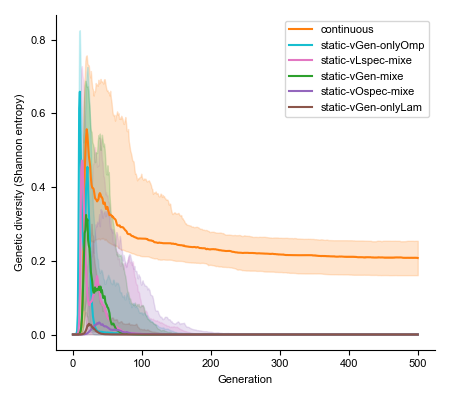

In [10]:
image = Image(str(simulation_set_path) + '/shannon_aggregate-allmodels.png')
display(image)

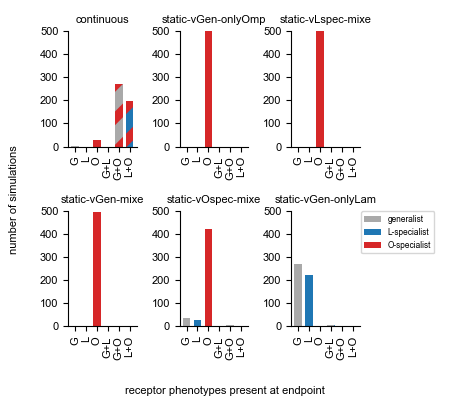

In [8]:
image = Image(str(simulation_set_path) + '/endpointphenotypes-allmodels.png')
display(image)



### Note on tuning the scale parameter for drawing per-simulation landscapes

Since our experimental measurements of the fitness landscapes are not perfect (i.e., there is experimental noise in the measurements: Pearson correlation in selection rates across **replicate virus libraries (the main source of experimental noise)** ranging from 0.95-0.98), we developed a way for replicate evolution simulations to use fitness landscapes that are drawn on a per-simulation basis from a distribution of landscapes. The mean fitness values are centered on the average across the experimental measurements, and normally-distributed noise is added on a per-simulation basis to each fitness value. The degree of normal noise is scaled to result in a correlation coefficient between replicate simulation landscapes similar to that of replicate experimental library experiments. 

To achieve this, we will add normally-distributed noise centered on 0 to the fitness measurements using the `numpy` function `normal`, and we will tune the `scale` parameter such that replicate draws of fitness landscapes with a given `scale` result in fitness correlations similar to the experimental results. Based on these results we used a scale parameter of 0.6 in the simulations above.

Here is the correlation between experimental libraries:


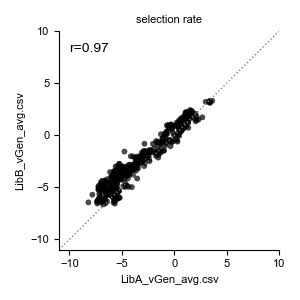

Here are the correlations for varying scale of noise:


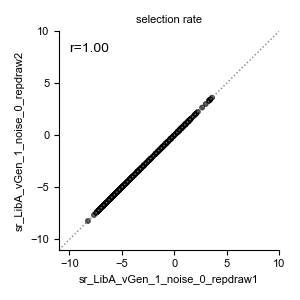

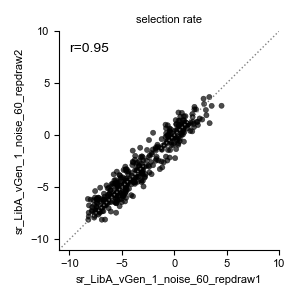

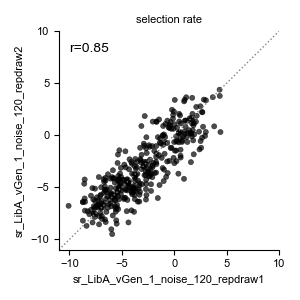

In [30]:
# pick an experimentally measured landscape for tuning noise. 
# can repeat with others to see generally similar results for a given scale parameter.
sample = 'LibA_vGen_1'

# make the correlation plot of the average library A vs. average library B corresponding to this sample;
# we will compare this correlation to the correlation between noise-added landscapes below.
sr_path_prefix = str(sr_files_path) + '/sr_' 
library_A_avg_file = sr_path_prefix + sample.replace('1','avg') + '.csv'
library_B_avg_file = library_A_avg_file.replace('LibA','LibB')
label1 = library_A_avg_file[library_A_avg_file.find('Lib'):]
label2 = library_B_avg_file[library_B_avg_file.find('Lib'):]
command = 'python ./scripts/plot_srcorr.py %s %s %s %s %s\n' % \
        (library_A_avg_file, library_B_avg_file, label1, label2, str(noisetune_path))
subprocess.call(command, shell=True)

print("Here is the correlation between experimental libraries:")
pngfile = label1 + "-vs-" + label2 + ".png"
image = Image(str(noisetune_path) + "/" + pngfile)
display(image)

file = str(sr_files_path) + '/sr_%s.csv' % sample
landscape = pd.read_csv(file, index_col=0, nrows=512).to_numpy().flatten()
image_list = []

for noise in [0.0, 0.6, 1.2]: # these are used for the scale parameter of numpy's normal fcn
    noised_files = [] # list of replicate draws of noise-added landscapes
    for noiserep in [1,2]: # make two replicate draws of noise-added landscapes
        noise_array = normal(size=512,loc=0, scale=noise)
        noised_landscape = landscape + noise_array
        noised_filestr = str(noisetune_path) + '/' + file[file.find('sr_%s' % sample):].rstrip('.csv') + '_noise_%s_repdraw%s' % (int(noise*100),noiserep) + '.csv'
        noised_files.append(noised_filestr)
        
        # write the noise-added landscape to file
        srnoisefileout = open(noised_filestr,'w')
        srnoisefileout.write('genotype,sr_with_noise_%s\n' % int(noise*100))
        for i,gt in enumerate(myutils.construct_genotype_space()):
            srnoisefileout.write('%s,%s\n' % (gt,noised_landscape[i]))
        srnoisefileout.close()
    
    # plot sr correlation between noiserep1 and noiserep2 showing effect of replicate draws with this noise parameter    
    label1 = noised_files[0][noised_files[0].find('sr_%s' % sample):].rstrip('.csv')
    label2 = noised_files[1][noised_files[0].find('sr_%s' % sample):].rstrip('.csv')
    command = 'python ./scripts/plot_srcorr.py %s %s %s %s %s\n' % \
        (noised_files[0], noised_files[1], label1, label2, str(noisetune_path))
    subprocess.call(command, shell=True)
    
    pngfile = label1 + "-vs-" + label2 + ".png"
    image_list.append(Image(str(noisetune_path) + "/" + pngfile))

print("Here are the correlations for varying scale of noise:")
display(*image_list)